In [ ]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 224041421 / HD 173928 / WDS J18488-1836AB / Gaia DR3 4098425954745263104  Analysis (EA)

- some uncertainty in ID, the target is a known visual double star (separation 0.4" per WDS).
  - The 2 stars are not resolved by Gaia DR3 either
- new VSX entry


## TESS Data

In [2]:
tic = 224041421

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
# sr = sr[sr.author == "QLP"]  # for uniformity, only 1 sector (3) has no QLP data
# sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 92,2025,SPOC,120,224041421,0.0,N/A


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 224041421" SECTOR=92 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

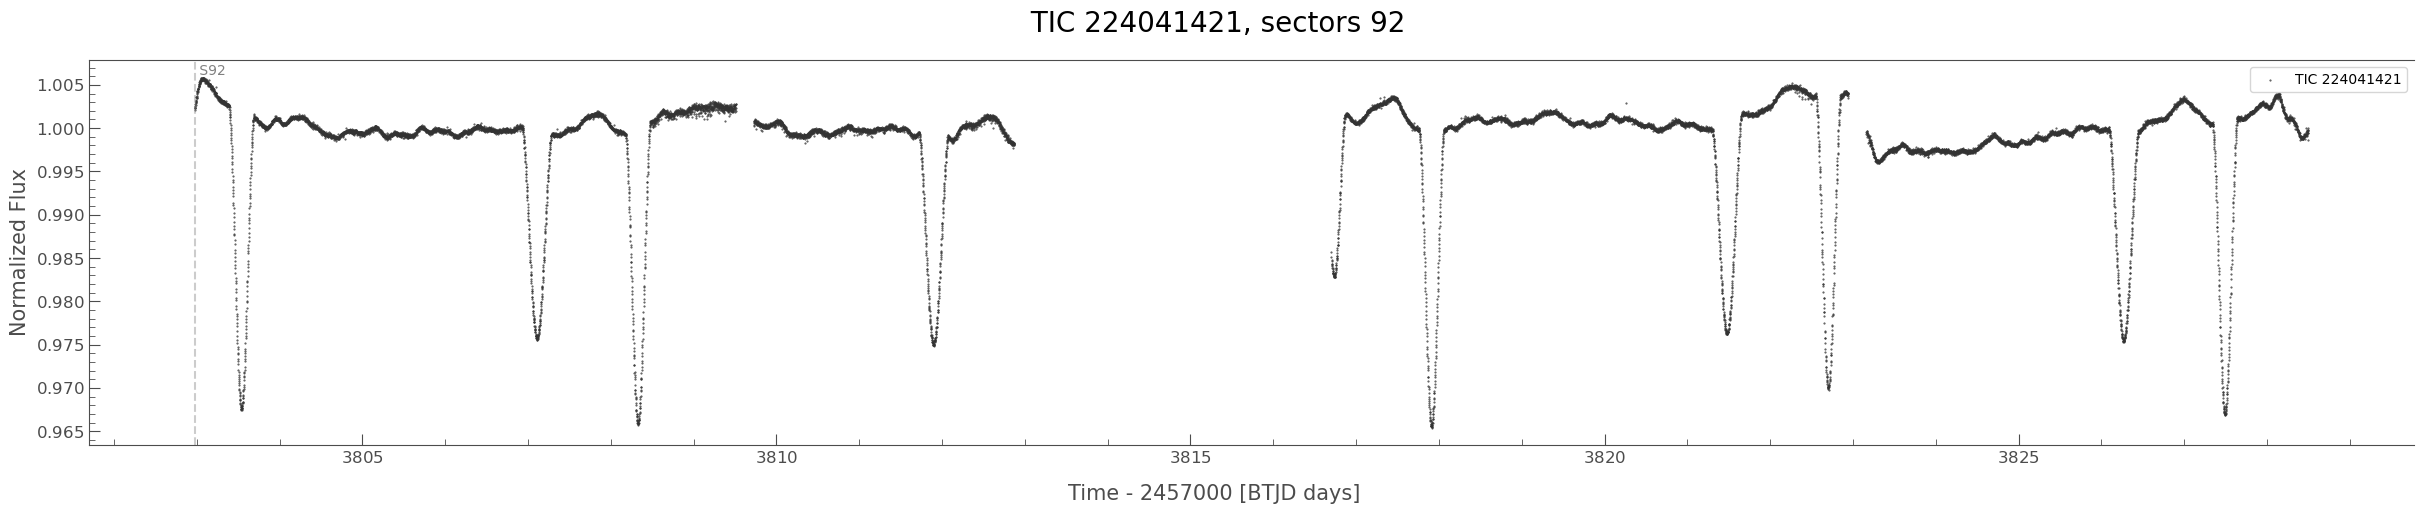

In [157]:
lc = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.select_flux("flux").normalize(), ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=1, alpha=0.9);
axs[0].get_figure().suptitle(f" {lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
# [ax.set_ylim(0.9985, 1.001) for ax in axs];

### The TESS photomery appears to suffer saturation issue

eclipse depth is proabably smaller than actual depth

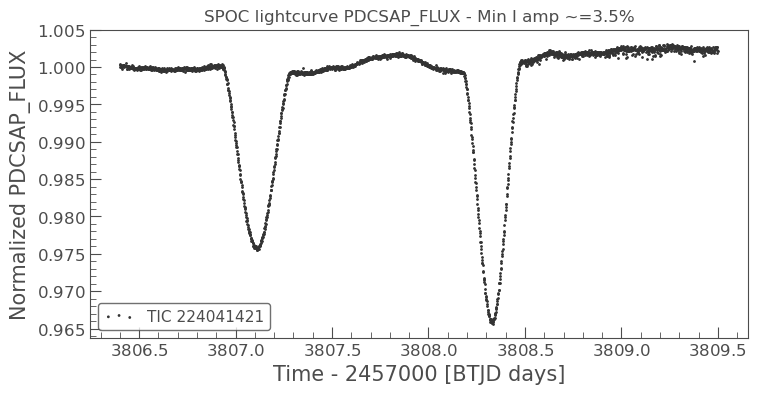

In [165]:
ax = tplt.scatter(lc.truncate(3806.4, 3809.5));
ax.set_ylabel("Normalized PDCSAP_FLUX");
ax.set_title("SPOC lightcurve PDCSAP_FLUX - Min I amp ~=3.5%");

<p style="font-size: 18px;">Lightcurve from pixel data with SPOC aperture, roughly SAP_FLUX - Min I depth ~= 3.5% </p>

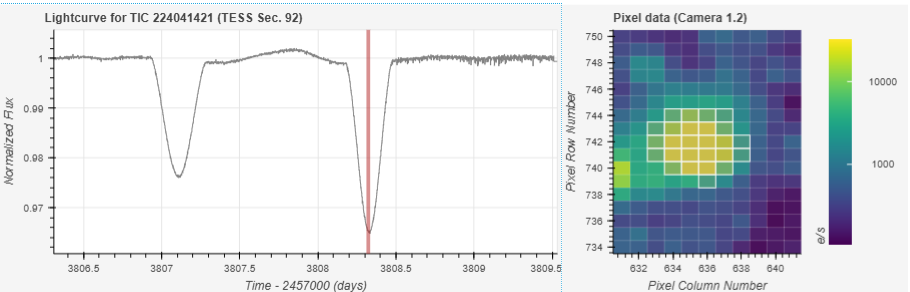

---

<p style="font-size: 18px;">SPOC aperture with 4 saturated pixels removed - Min I depth ~= 6% </p>

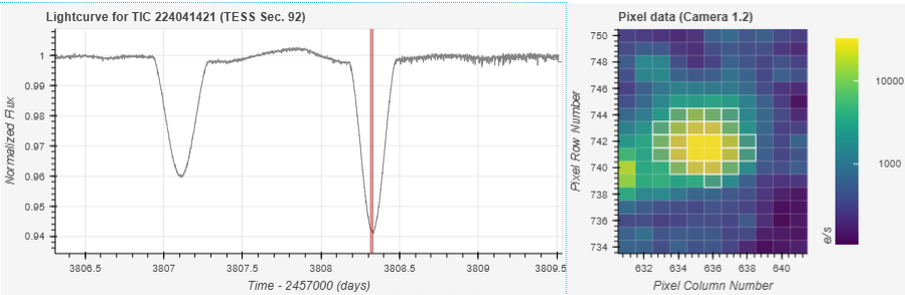


Note: TESS TCEs identify the eclipses.
https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2025127110927-s0092-s0092-0000000224041421-01014_dvm.pdf

The TCE centorid is not reliable as the pixels near the target are saturated or near saturated. Per-pixel plot suggests the eclipses are on target.

## ASAS3 data

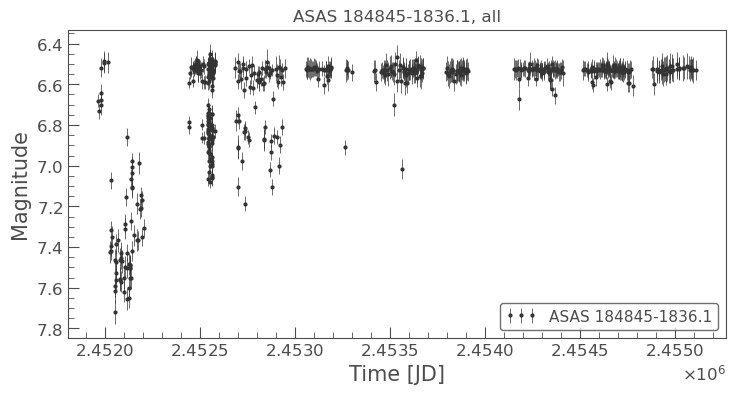

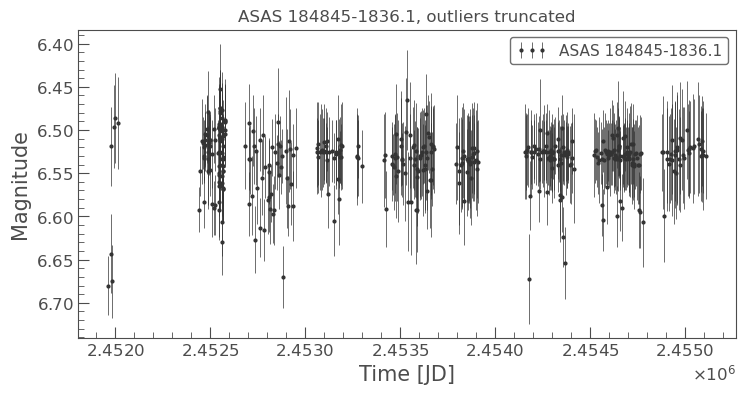

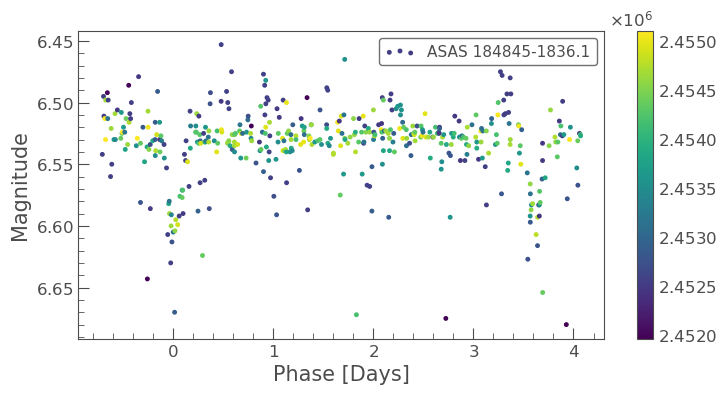

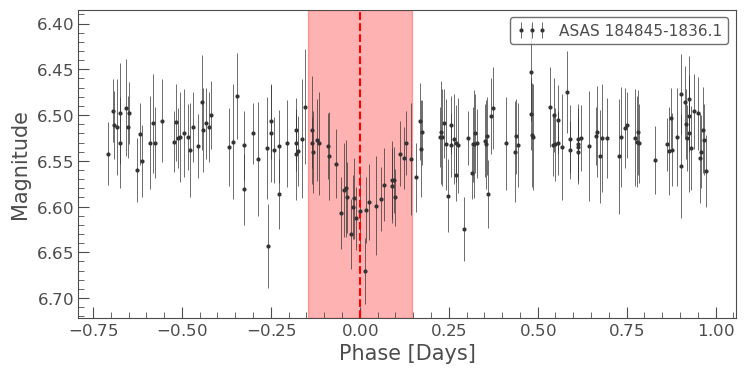

In [4]:
import lightkurve_ext_readers as lker

_lc = lker.read_asas3("https://www.astrouw.edu.pl/cgi-asas/asas_cgi_get_data?184845-1836.1,asas3")
ax = tplt.errorbar(_lc);
ax.set_title(_lc.label + ", all");

# lots of data points much fainter than the expected range, especially before HJD 2453000
# _lc = _lc.truncate(2453000, None) 
_lc = _lc.truncate(None, 6.7, column="flux") 
ax = tplt.errorbar(_lc);
ax.set_title(_lc.label + ", outliers truncated");

_lc_f = _lc.fold(period=4.79067, epoch_time=2460803.54, wrap_phase=4.7906*0.85)  # rough initial epoch / period to gauge usefulness of the data
ax = tplt.scatter(_lc_f, s=25, c=_lc_f.time_original.value);

ax = tplt.errorbar(_lc_f.truncate(-1, 1));
ax.axvline(0, color="red", linestyle="--");
ax.axvspan(-7/24/2, 7/24/2, color="red", alpha=0.3);

# use the outlier-truncated version
lc_asas3 = _lc 

## Hipparcos  data

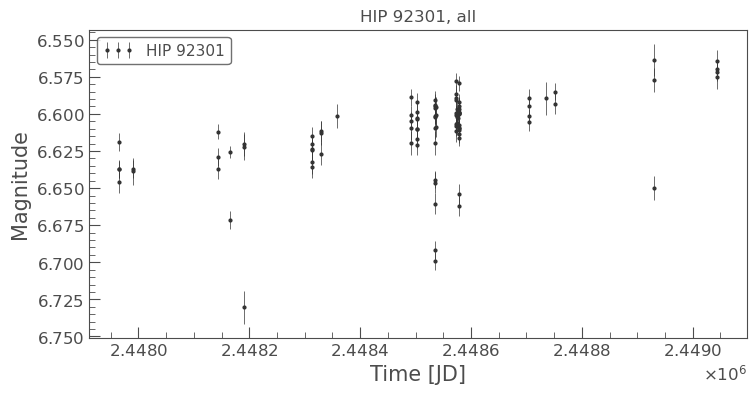

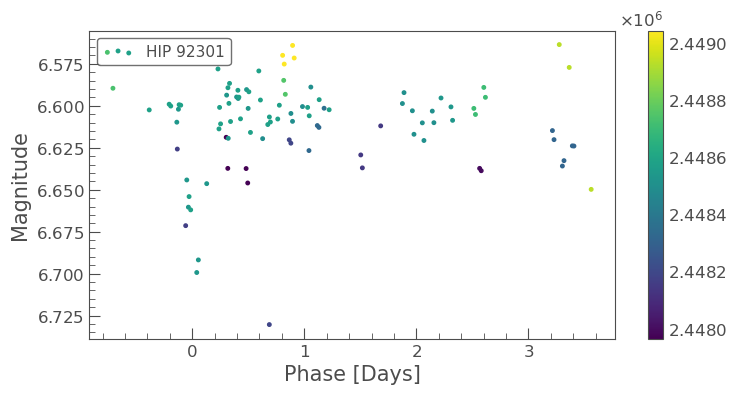

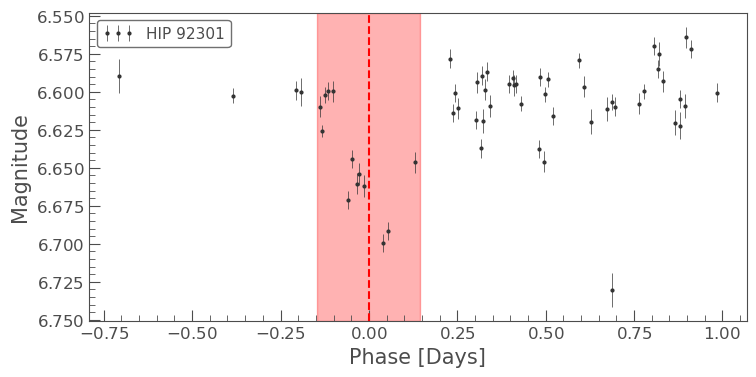

In [24]:
_lc = lker.read_hipparcos_data("https://cdsarc.cds.unistra.fr/viz-bin/nph-Plot/Vgraph/txt?I/239/92301")
ax = tplt.errorbar(_lc);
ax.set_title(_lc.label + ", all");


_lc_f = _lc.fold(period=4.79067, epoch_time=2460803.54, wrap_phase=4.7906*0.85)  # rough initial epoch / period to gauge usefulness of the data
ax = tplt.scatter(_lc_f, s=25, c=_lc_f.time_original.value);

ax = tplt.errorbar(_lc_f.truncate(-1, 1));
ax.axvline(0, color="red", linestyle="--");
ax.axvspan(-7/24/2, 7/24/2, color="red", alpha=0.3);

# use the outlier-truncated version
lc_hip = _lc 

## Gaia DR3 info (coordinate, etc.)

In [5]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext.py:1972: UserWarning: gaia_dr3_mag_to_vmag(): b_minus_r value (--) is outside the applicable range for the transformation. The result is probably not reliable.
  warnings.warn(


flag,_r,_p,Source,RPmag,Gmag,BPmag,BP-RP,Vmag,Teff,RUWE,sepsi,epsi,NSS,Plx,pmRA,pmDE,VarFlag,RV,e_RV,IPDfmp,Dup,RAJ2000,DEJ2000,EpochPh,EpochRV
,arcsec,deg,,mag,mag,mag,mag,mag,K,,,mas,,mas,mas / yr,mas / yr,,km / s,km / s,,,deg,deg,,
str4,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,str48,float64,float64,float64,str34,float64,float32,int16,uint8,float64,float64,uint8,uint8
!! ✓,0.000,0.0,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=4098425954745263104&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET'>4098425954745263104,5.453,6.397,6.660,1.207,6.696,5819.2,2.302,106,0.405,0,3.4000,2.990,-1.312,NOT_AVAILABLE,-31.91,0.13,98,0,282.18922114884,-18.60115749840,0,0
!,7.311,186.1,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=4098425954704434048&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET'>4098425954704434048,15.148,19.259,16.745,1.597,19.755,--,--,2.64,1.974,0,--,--,--,NOT_AVAILABLE,--,--,0,0,282.18900905659,-18.60318282333,0,0
!,8.099,150.5,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I

The target is also listed as an astrometric binary with 177.74 d (+/- 1.33 d) period in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65a1a2351812e4&-source=I%2F357&Source=5483610730803645312)


In [6]:
# primary_name = f"TIC {tic}"
primary_name = "HD 173928"   # use the more common HD name instead of TIC, as I no longer use TESS data exclusively
primary_name

'HD 173928'

## Combining all data


TESS # data points: 16958
ASAS3 # data points: 440
HIP # data points: 98
Masking out distorted cadence near a momentum dump
TESS # data points: 16923
ASAS3 # data points: 440
HIP # data points: 98


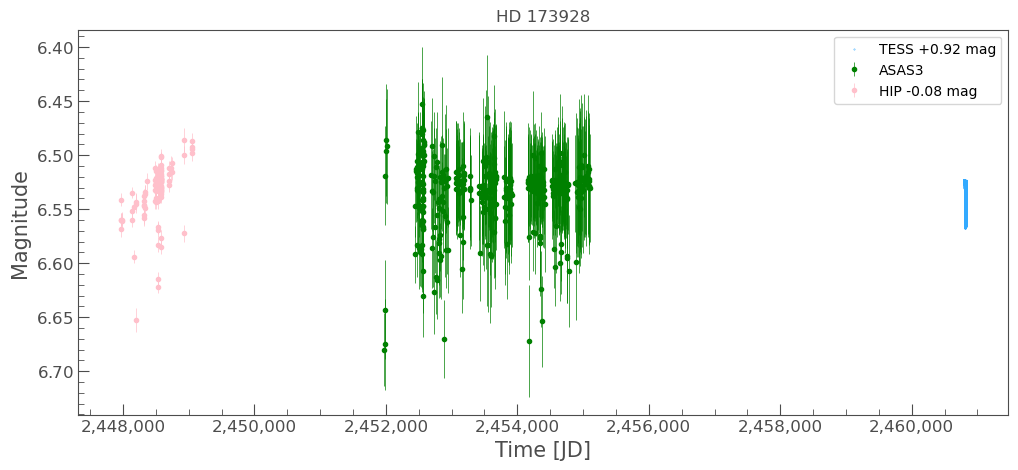

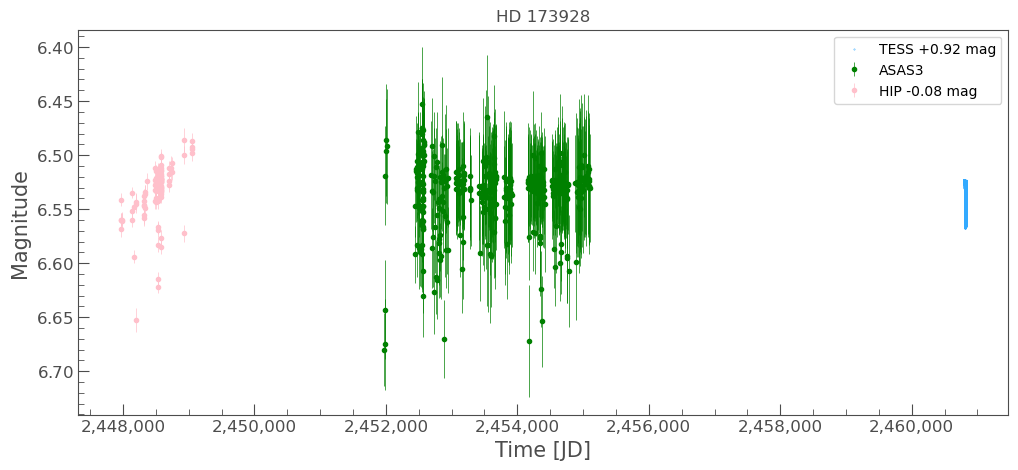

In [30]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS3": lc_asas3,
     "HIP": lc_hip,
    }, 
    shift_to="ASAS3",
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
# plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0

# in PDCSAP_FLUX, the data near a momentum dump is distorted, affecting the dips
print("Masking out distorted cadence near a momentum dump")

lc_tess = lke.exclude_range(lc_tess, 2460816.65, 2460816.75)  
lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS3": lc_asas3,
     "HIP": lc_hip,
    }, 
    shift_to="ASAS3",
)
for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))
ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);


##  epoch / period / duration

### Initial epoch / period / duration


In [33]:
list(lc_combined_dict.keys())

['TESS', 'ASAS3', 'HIP']

<Axes: xlabel='Phase (Normalized)', ylabel='Magnitude'>

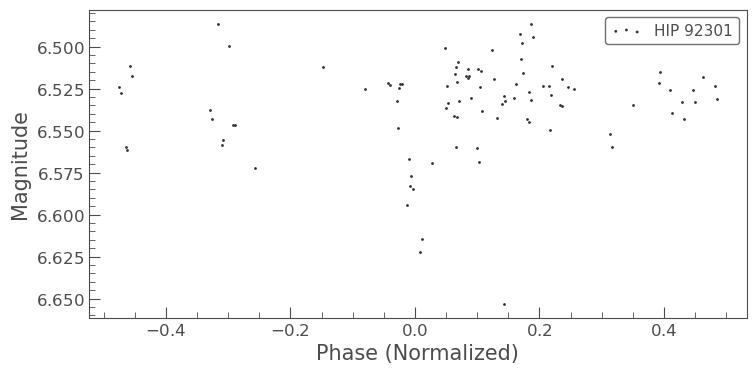

In [36]:
tplt.scatter(lc_f_res["HIP"])

In [40]:
plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[2]

('errorbar', {'marker': '.', 'c': 'pink', 'linewidth': 0.5, 'ls': 'none'})

Adopted period / epoch / duration_hr:  4.79067 2460803.54 7.0 8.0
Min II phase: -0.255


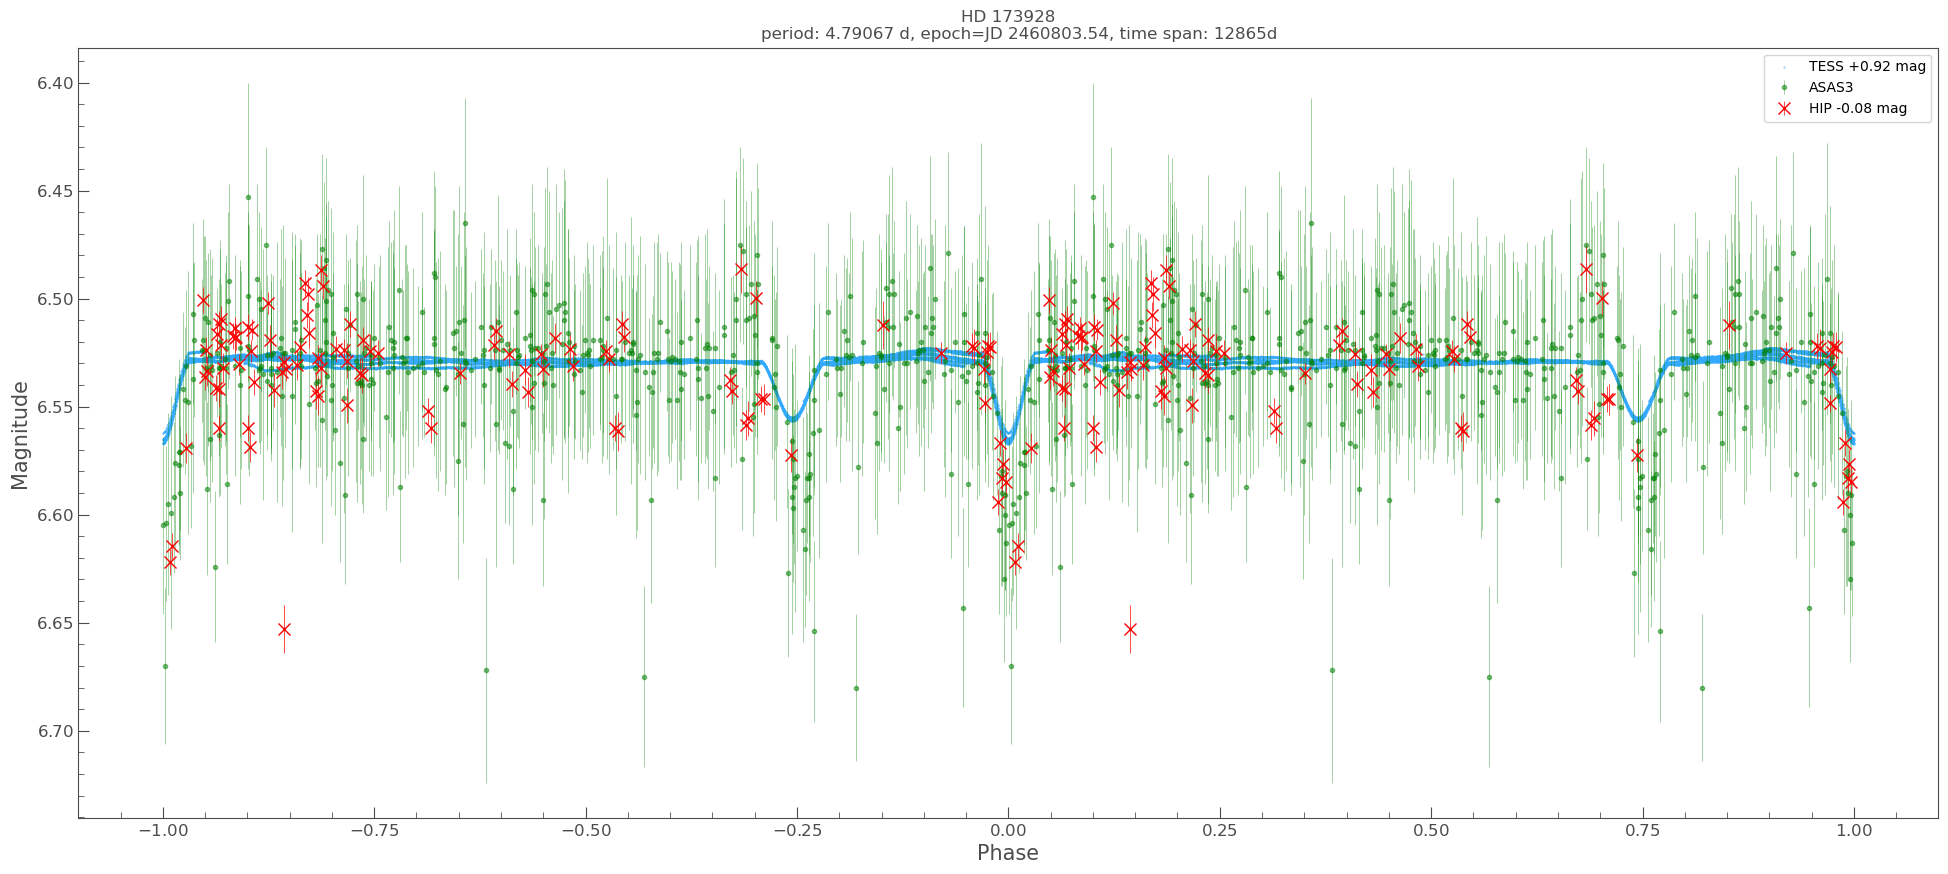

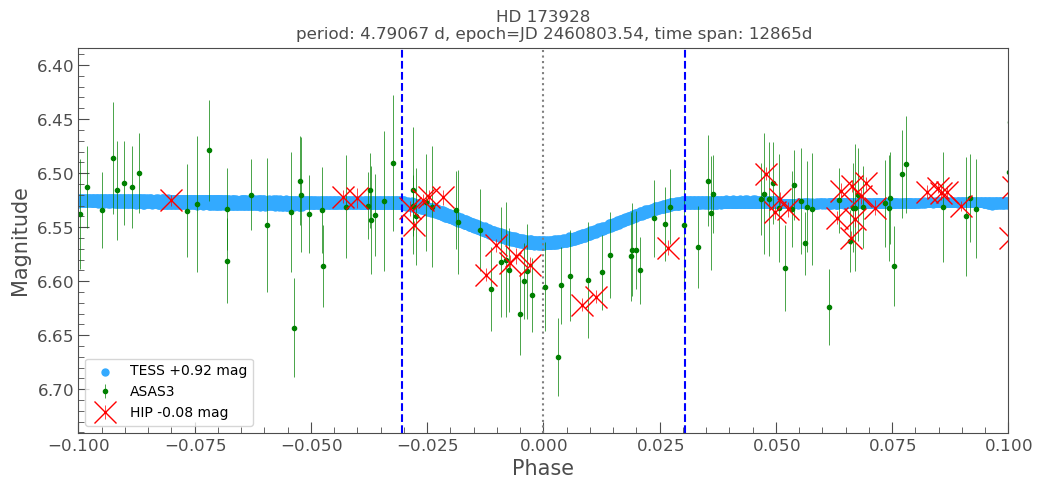

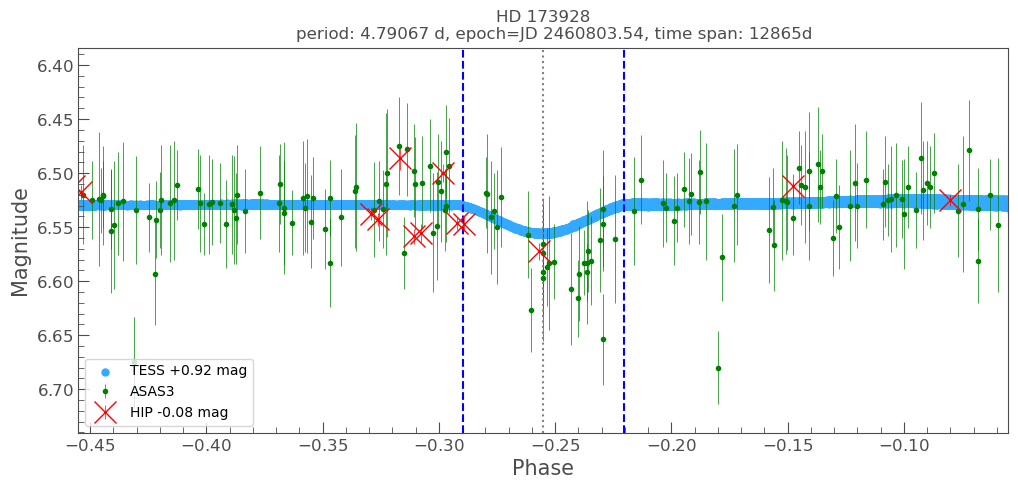

In [61]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_trial = 4.791  # TCE1 4.79062 [0.0001], TCE2: 4.79069 [0.00021]
period_trial = 4.79067  # rough visual fit with ASAS3 + TESS
epoch_time_btjd_trial = 3803.54  # TCE1
epoch_time_hjd_trial = round(lket.btjd_to_hjd_utc(epoch_time_btjd_trial, target_coord), 2)  
epoch_time_min_ii_btjd_trial = 3807.11   #  TCE2
epoch_time_min_ii_hjd_trial = round(lket.btjd_to_hjd_utc(epoch_time_min_ii_btjd_trial, target_coord), 2) 

duration_hr_min_i_trial = 7.0
duration_hr_min_ii_trial = 8.0

epoch_phase_min_ii_trial   = abs(epoch_time_min_ii_btjd_trial   - epoch_time_btjd_trial  ) / period_trial   % 1
if epoch_phase_min_ii_trial   > 0.5:
    epoch_phase_min_ii_trial   = epoch_phase_min_ii_trial   - 1
epoch_phase_min_ii_trial  = round(epoch_phase_min_ii_trial  , 3)  # precsion from eyeballing zoomed plot

print("Adopted period / epoch / duration_hr: ", period_trial, epoch_time_hjd_trial, duration_hr_min_i_trial, duration_hr_min_ii_trial)
print("Min II phase:", epoch_phase_min_ii_trial)

# --- Plot them to verify ---

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1][1]["alpha"] = 0.5  # make ASAS3 data less dense visually
plot_options[2][1]["c"] = "red"  # make the relative sparse HIP data more prominent
plot_options[2][1]["marker"] = "x"
plot_options[2][1]["markersize"] = 9
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    # {"TESS": lcc_tess[-1].select_flux("sap_flux").normalize() }, 
    period=period_trial,
    epoch=Time(epoch_time_hjd_trial   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
plot_options_zoom[2][1]["c"] = "red"   # make the relative sparse HIP data more prominent
plot_options_zoom[2][1]["marker"] = "x"
plot_options_zoom[2][1]["markersize"] = 16
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    dict(TESS=lc_combined_dict["TESS"], ASAS3=lc_combined_dict["ASAS3"], HIP=lc_combined_dict["HIP"]), 
    period=period_trial  ,
    epoch=Time(epoch_time_hjd_trial   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_trial  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_trial  ,
    epoch=Time(epoch_time_hjd_trial   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_trial  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_trial  ,
    plot_options=plot_options_zoom,
    figsize=(12, 5),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(epoch_phase_min_ii_trial, c="gray", linestyle="dotted");
ax.set_xlim(epoch_phase_min_ii_trial  -0.2, epoch_phase_min_ii_trial  +0.2);  # to see Min II in details


### Refine the period with MCMC on primary eclipses

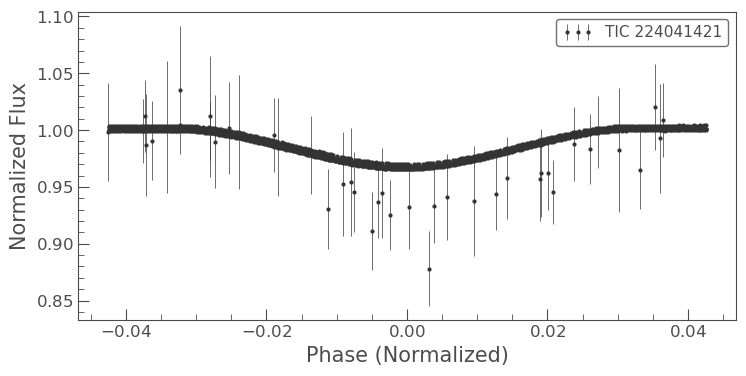

In [116]:
# reload(lke)

# a single normalized lightcurve
lc = lke.stitch_lc_dict(lc_combined_dict, normalize=True).remove_nans()
lc.meta["LABEL"] = primary_name
# tplt.scatter(lc);

lc_f_min_i = lc.fold(epoch_time=epoch_time_hjd_trial, period=period_trial, normalize_phase=True)
lc_f_min_i = lc_f_min_i.truncate((0 - duration_hr_min_i_trial / 24 * 0.7) / period_trial, (0 + duration_hr_min_i_trial /24 * 0.70) / period_trial)
# ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value, s=25);
ax1 = tplt.errorbar(lc_f_min_i);



In [117]:
from types import SimpleNamespace

import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions
# reload(etv_functions)

lc_f = lc_f_min_i

# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalixed phase
start_vals = [1.0, -0.04, 0, 0.015, 0.9]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "0", *start_vals)

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

100%|██████████████████████████████████████████████████████████| 4000/4000 [03:01<00:00, 22.08it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 200;
tau: [ 27.81045369 151.58707289  65.5606372  219.81411085 244.28643666
  26.53826298]


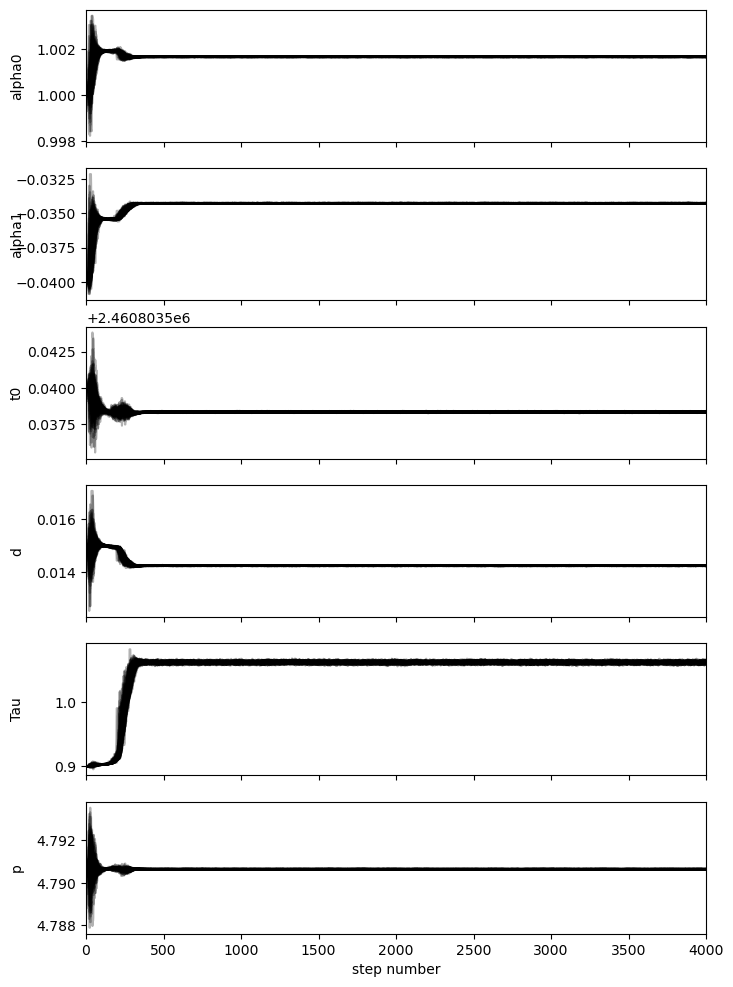

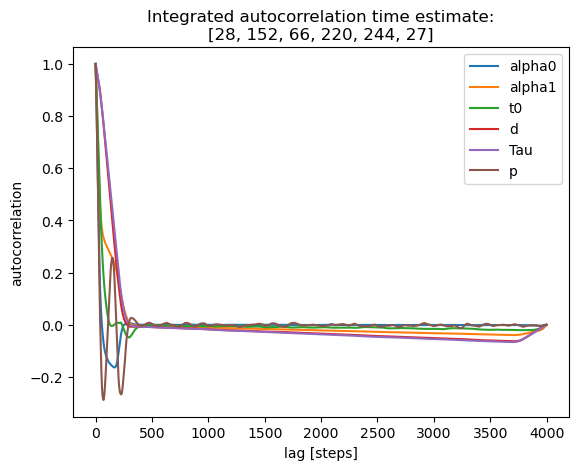

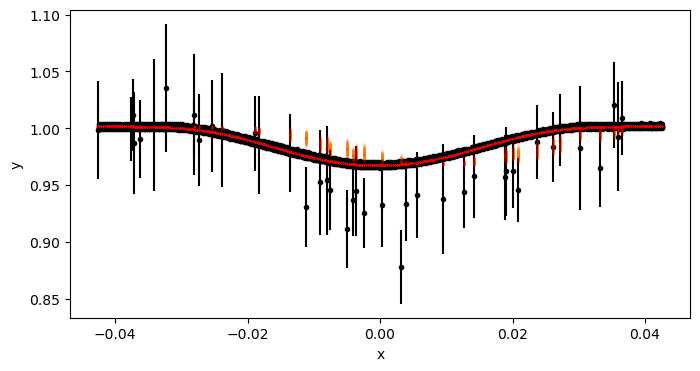

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.001673120638677, -0.034259225719885246, 2460803.538330936, 0.014245162648944713, 1.0621599689649792, 4.790641885184387
std_p: 6.246509004632742e-06


In [122]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
    [1.0, -0.04, epoch_time_hjd_trial, 0.015, 0.9, period_trial],
    # nruns=20, discard=1,
    nruns=4000, discard=1000,
    # nruns=5000, discard=4000,
    autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient    
    pool=-2, 
    plot_chains=True, plot_autocorrelation=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_p:", fit_params_p_stats["std_p"])


### Trying a set of different periods with visual inspection

MCMC result is unsatifactory (worse than my initial fit)


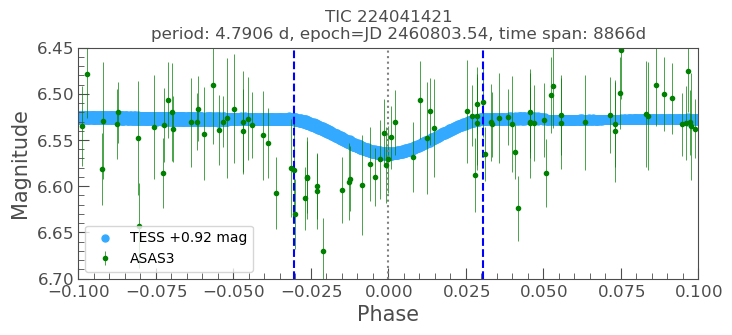

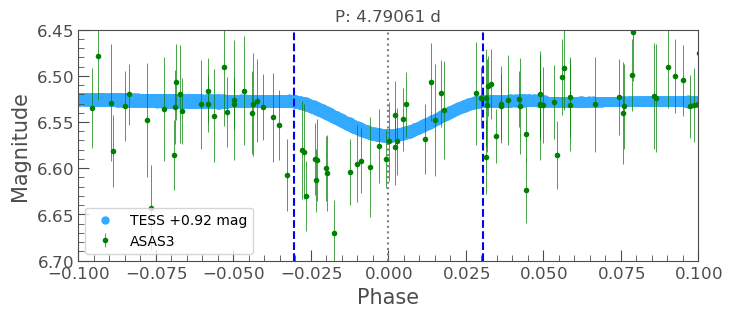

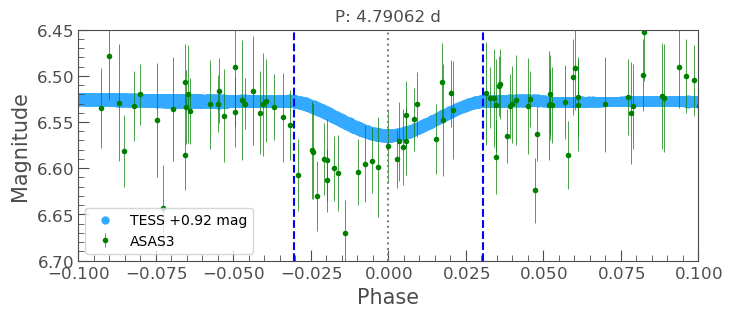

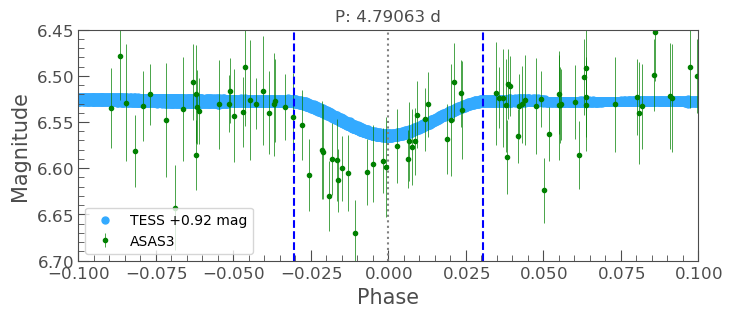

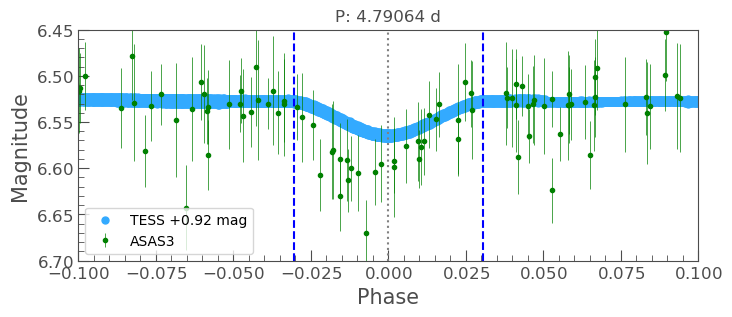

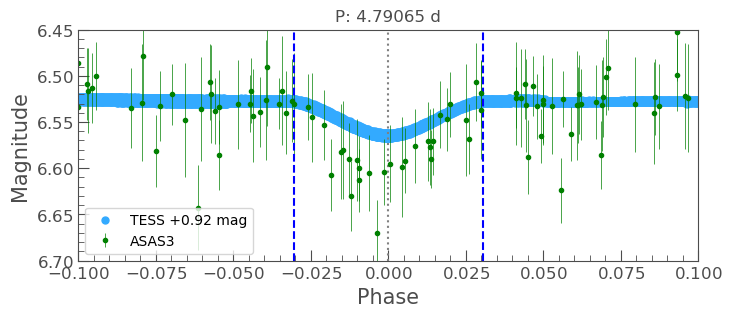

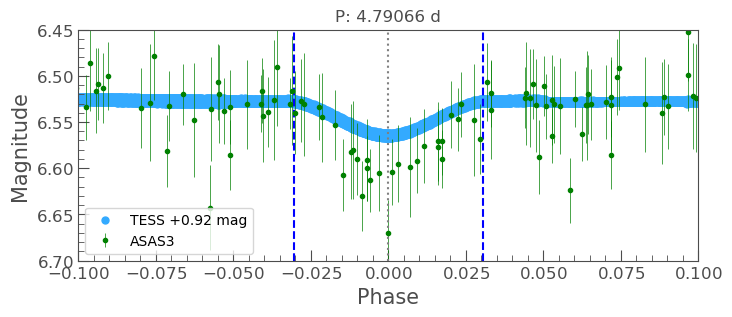

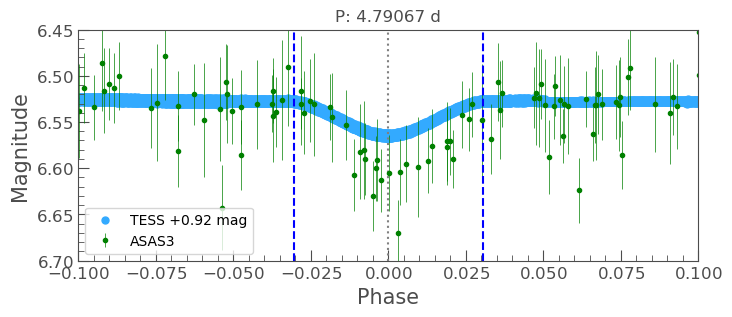

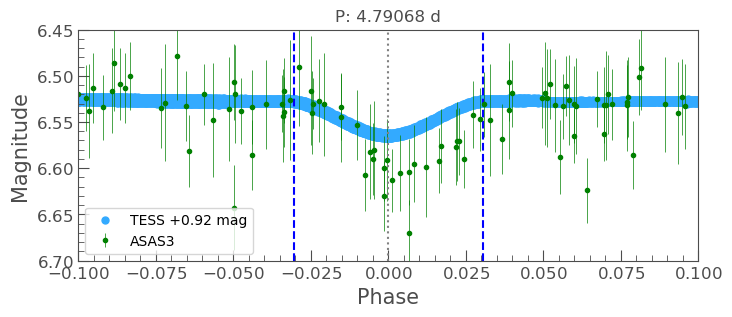

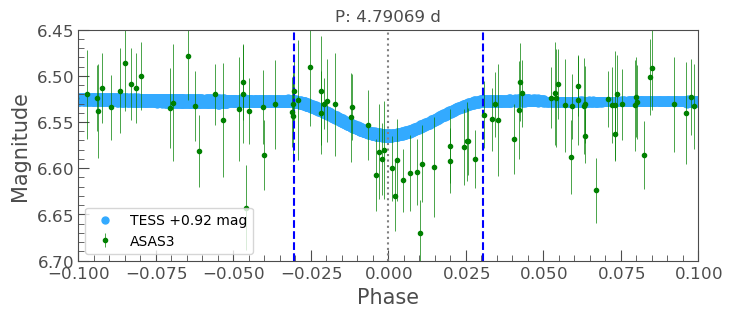

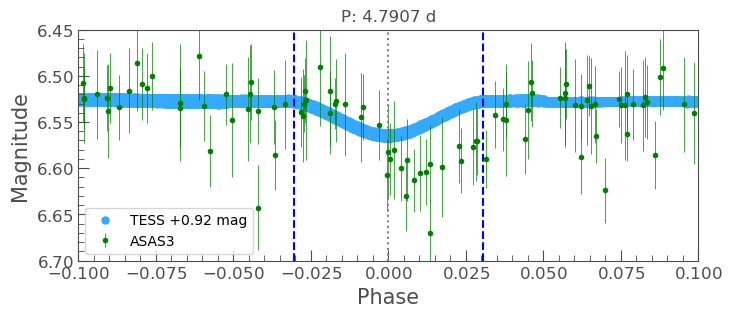

In [136]:

for i, _period in enumerate([4.79060 , 4.79061, 4.79062, 4.79063, 4.79064, 4.79065, 4.79066, 4.79067, 4.79068, 4.79069, 4.79070 ][:]):  # np.arange(4.79060, 4.79071, 0.00001)
    # zoom plot Min I
    # - make TESS more visible:  larger dots
    plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
    plot_options_zoom[0][1]["s"] = 25
    ax, lc_f_res = lkem.fold_n_plot_multi_bands(
        lc_combined_dict,
        period=_period,
        epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
        phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
        target_name=primary_name,
        duration_hr=duration_hr_min_i_final  ,  # for plotting only
        figsize=(8, 3),
        plot_options=plot_options_zoom,
        # mag_shift_precision=2,  #
    );
    ylim = (6.7, 6.45)
    ax.set_ylim(*ylim);
    ax.legend(loc="lower left");
    ax.axvline(0, c="gray", linestyle="dotted");
    ax.set_xlim(-0.1, 0.1);  # to see primary in details
    if i > 0:  # abbrevate the plot title
        ax.set_title(f"P: {_period} d")


### Final epoch / period / duration


Adopted period / epoch / duration_hr:  4.79066 2460803.54 7.0 8.0
Min II phase: -0.255


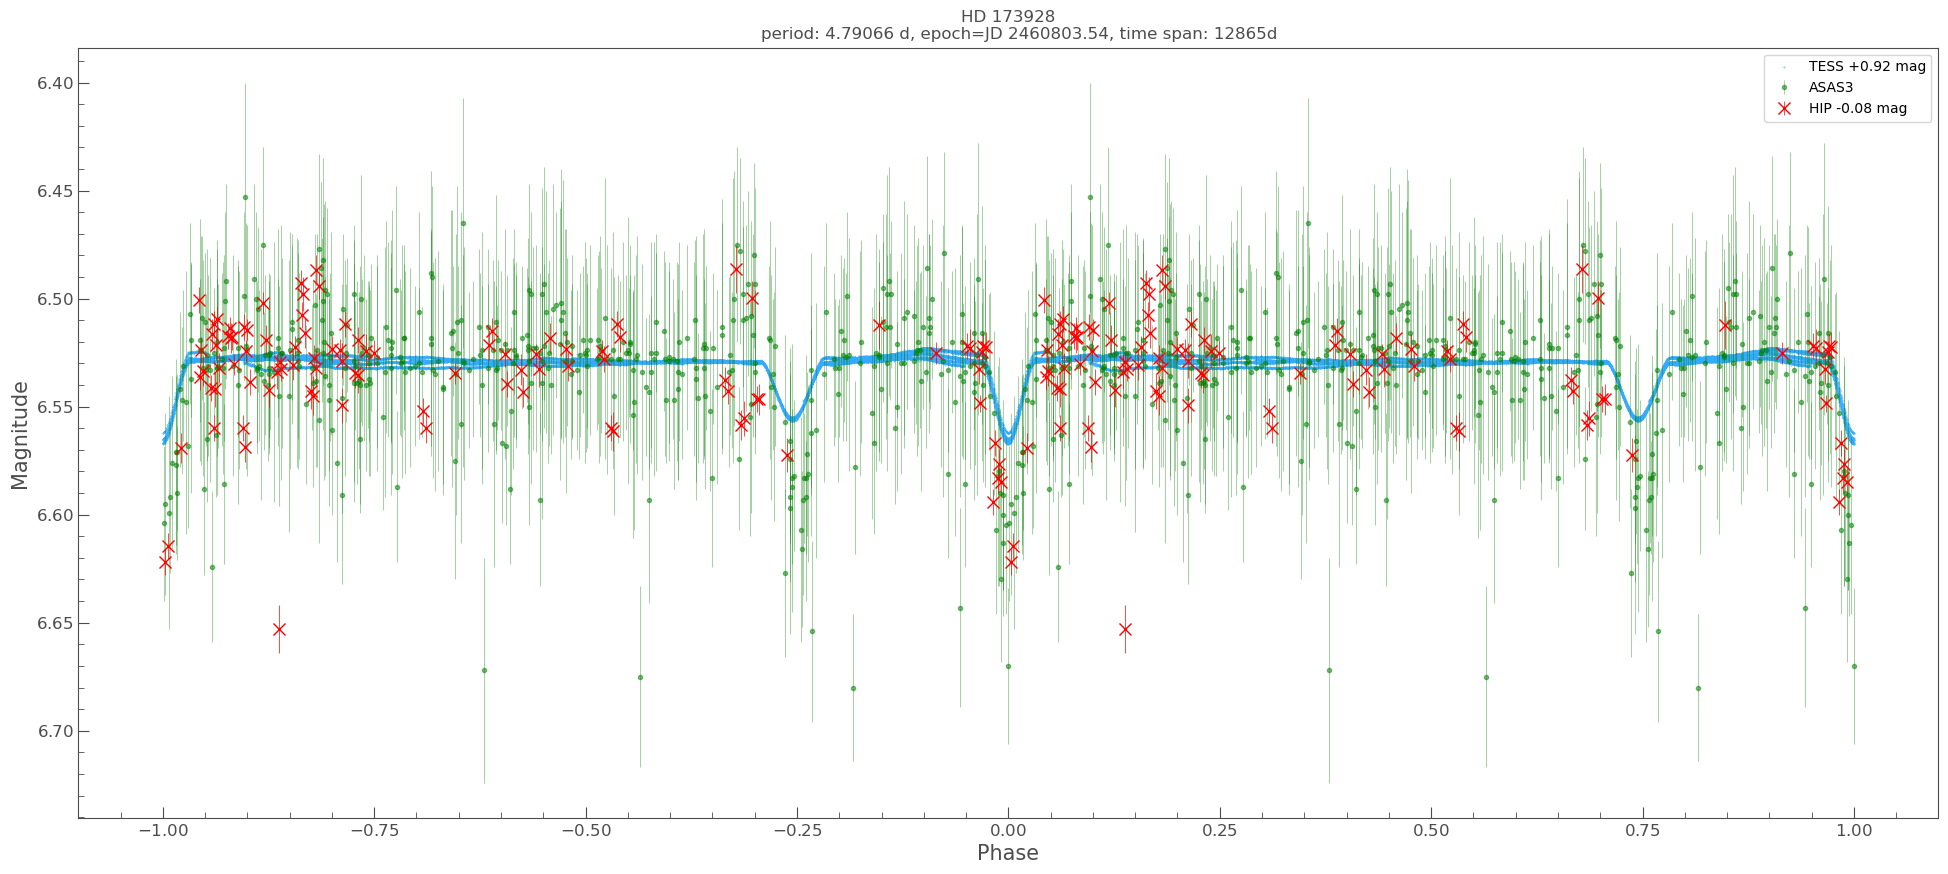

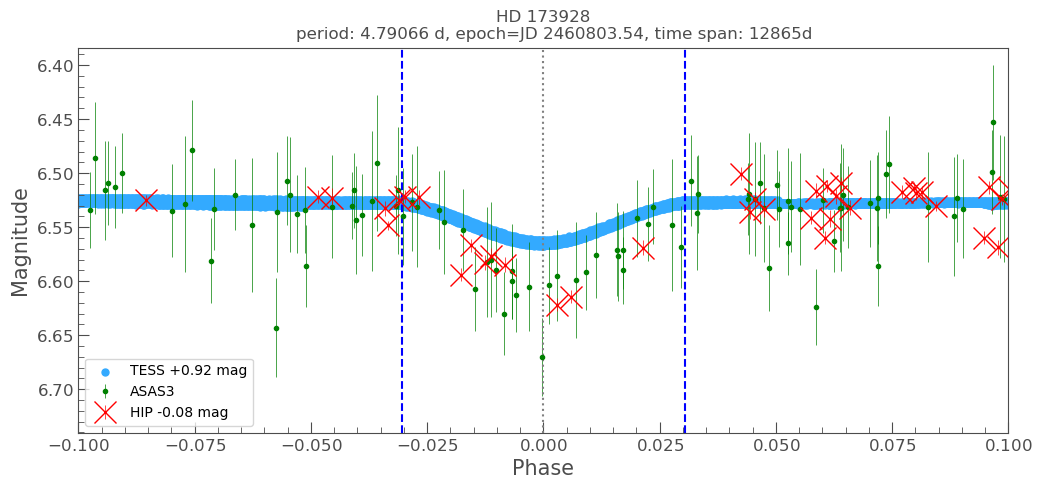

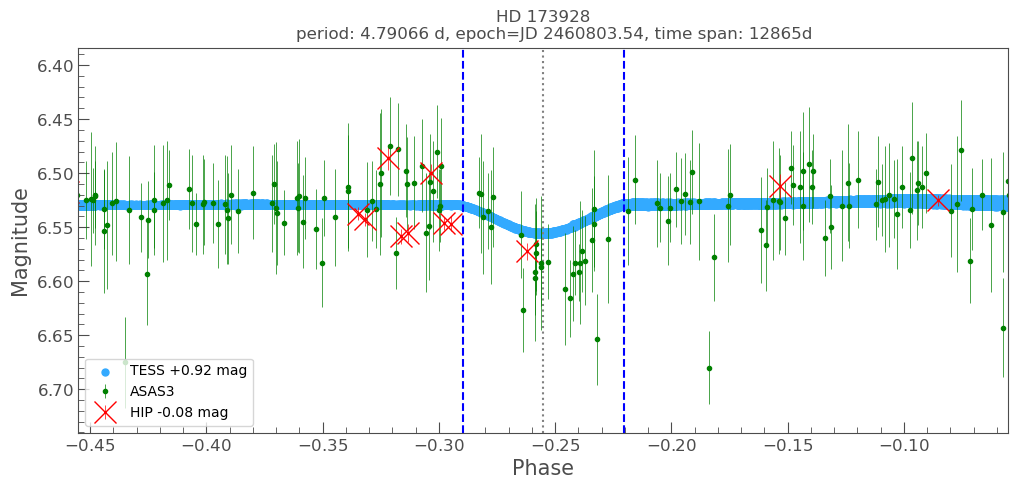

In [63]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = 4.79066   # from visual inspection trial above
epoch_time_btjd_final = epoch_time_btjd_trial 
epoch_time_hjd_final = epoch_time_hjd_trial
epoch_time_min_ii_btjd_final = epoch_time_min_ii_btjd_trial
epoch_time_min_ii_hjd_final = epoch_time_min_ii_hjd_trial

duration_hr_min_i_final = duration_hr_min_i_trial
duration_hr_min_ii_final = duration_hr_min_ii_trial

#---

epoch_phase_min_ii_final   = abs(epoch_time_min_ii_btjd_final   - epoch_time_btjd_final  ) / period_final   % 1
if epoch_phase_min_ii_final   > 0.5:
    epoch_phase_min_ii_final   = epoch_phase_min_ii_final   - 1
epoch_phase_min_ii_final  = round(epoch_phase_min_ii_final  , 3)  # precsion from eyeballing zoomed plot

print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final, duration_hr_min_ii_final)
print("Min II phase:", epoch_phase_min_ii_final)

# --- Plot them to verify ---

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1][1]["alpha"] = 0.5  # make ASAS3 data less dense visually
plot_options[2][1]["c"] = "red"  # make the relative sparse HIP data more prominent
plot_options[2][1]["marker"] = "x"
plot_options[2][1]["markersize"] = 9
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
plot_options_zoom[2][1]["c"] = "red"   # make the relative sparse HIP data more prominent
plot_options_zoom[2][1]["marker"] = "x"
plot_options_zoom[2][1]["markersize"] = 16
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(12, 5),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(epoch_phase_min_ii_final, c="gray", linestyle="dotted");
ax.set_xlim(epoch_phase_min_ii_final  -0.2, epoch_phase_min_ii_final  +0.2);  # to see Min II in details


## Determine Magnitude Range


### Determine Magnitude Range (TESS) (not used)


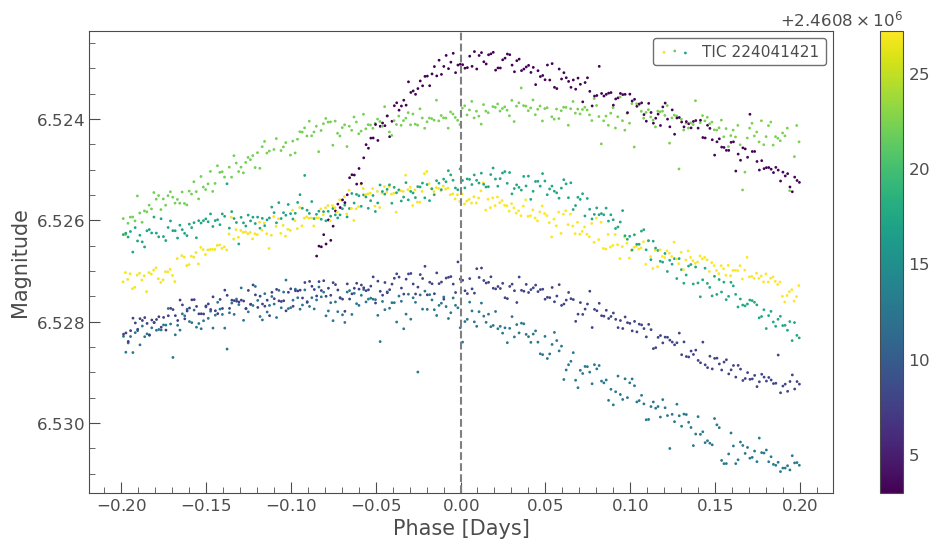

In [10]:
# zoom around max
lc = lc_combined_dict["TESS"]
# max is roughly at +4.33 d
lc_f = lc.fold(epoch_time=epoch_time_hjd_final + 4.31, period=period_final)  
lc_f_trunc = lc_f.truncate(-0.2, 0.2)
ax = tplt.lk_ax(figsize=(12, 6))
ax = tplt.scatter(lc_f_trunc , ax=ax, c=lc_f_trunc.time_original.value, s=4, alpha=1.0);
ax.axvline(0, color="gray", linestyle="--");


In [145]:
# determine max
for max_offset in [4.25, 4.26, 4.27, 4.28, 4.30, 4.31, 4.32, 4.33, 4.34, 4.35, 4.36, 4.37]:
    lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + max_offset, period=period_final).truncate(0 - 2 /24/60, 0 + 2 /24/ 60)
    # print("Max mag # num data points:", len(lc_zoom_max))
    max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
    print(max_offset, round(float(max_flux_mag), 4), len(lc_zoom_max))


4.25 6.5255 12
4.26 6.5257 12
4.27 6.5255 12
4.28 6.5254 12
4.3 6.5254 12
4.31 6.5253 12
4.32 6.5254 12
4.33 6.5254 12
4.34 6.5256 12
4.35 6.5256 12
4.36 6.5257 12
4.37 6.5256 12


Max mag # num data points: 30
Min I mag # num data points: 30
Min II mag # num data points: 20
['6.5254', '6.5290', '6.5655', '6.5559']
(0.04, 0.036, 0.027)


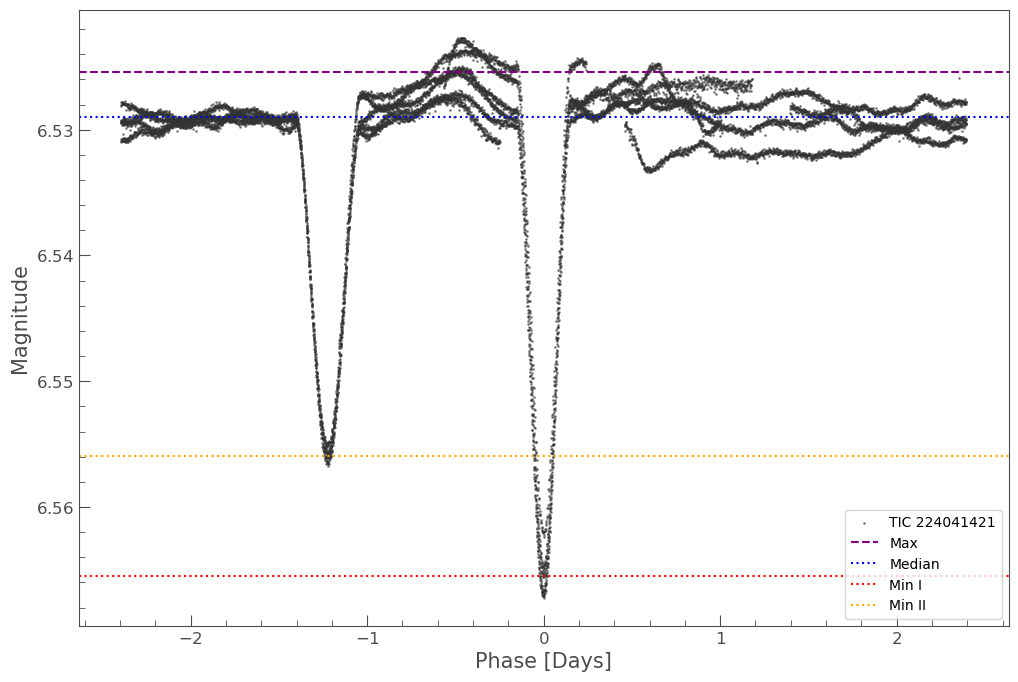

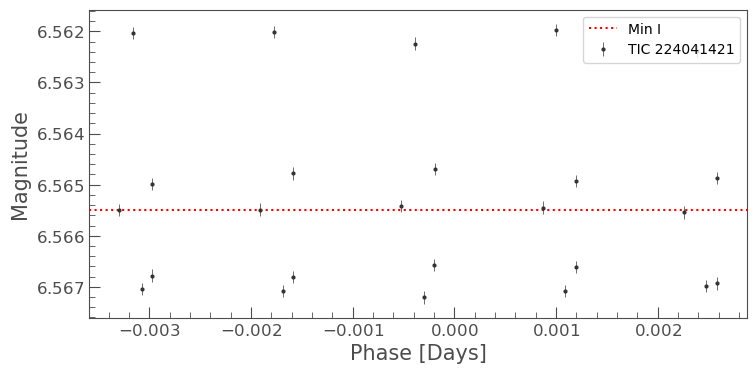

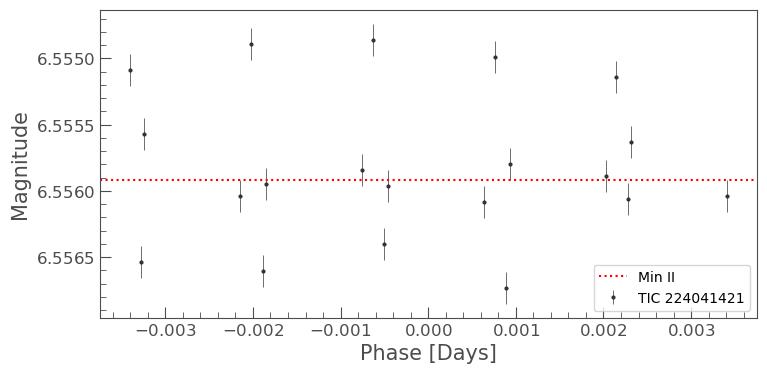

In [11]:
%matplotlib inline

median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + 4.31, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)  # the offset is from above cell
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)


lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd_final, period=period_final).truncate(0 - 5 /24/60, 0 + 5 /24/ 60)
print("Min II mag # num data points:", len(lc_zoom_min_ii))
min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)



lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ax.set_ylim(*ylim);

ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

ax = tplt.errorbar(lc_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [max_flux_mag, median_flux_mag, min_flux_mag, min_ii_flux_mag]])


# ampitude
amp_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)) , 3)  # in TESS band, probably don't have 4 digit precison

amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 3)  

amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 3)  

print((amp_flux_mag, amp_min_i_flux_mag, amp_min_ii_flux_mag))


### Determine range / amplitude (ASAS3)

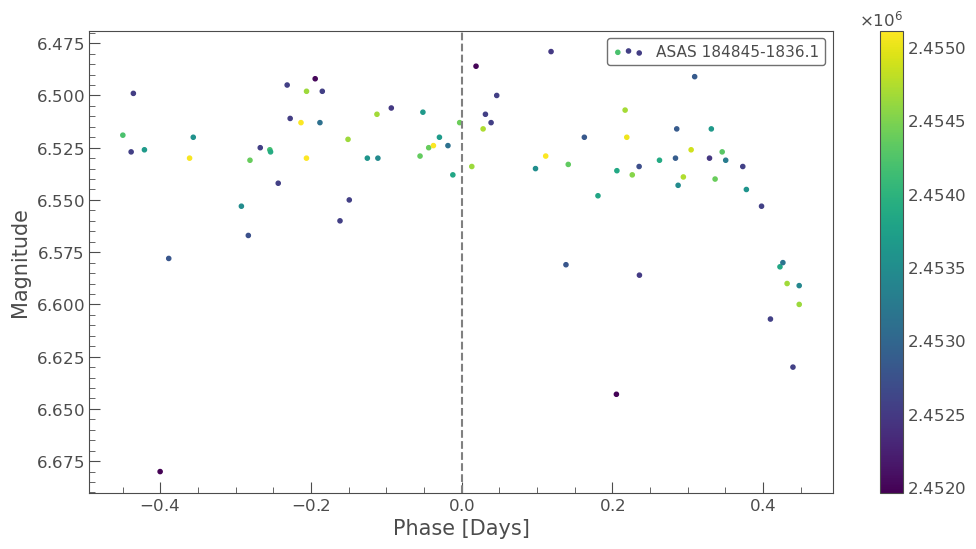

In [145]:
# zoom around max
lc = lc_combined_dict["ASAS3"]
# max is roughly at +4.31 d
lc_f = lc.fold(epoch_time=epoch_time_hjd_final + 4.31, period=period_final)  
lc_f_trunc = lc_f.truncate(-0.45, 0.45)
ax = tplt.lk_ax(figsize=(12, 6))
ax = tplt.scatter(lc_f_trunc , ax=ax, c=lc_f_trunc.time_original.value, s=36, alpha=1.0);
ax.axvline(0, color="gray", linestyle="--");


In [156]:
# determine max
for max_offset in [4.25, 4.26, 4.27, 4.28, 4.30, 4.31, 4.32, 4.33, 4.34, 4.35, 4.36, 4.37]:
    lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + max_offset, period=period_final).truncate(0 - 30 /24/60, 0 + 30 /24/ 60)
    # print("Max mag # num data points:", len(lc_zoom_max))
    max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
    print(max_offset, round(float(max_flux_mag), 4), len(lc_zoom_max))



4.25 6.525 3
4.26 6.524 5
4.27 6.524 5
4.28 6.524 5
4.3 6.522 4
4.31 6.524 5
4.32 6.5145 4
4.33 6.513 5
4.34 6.511 6
4.35 6.511 4
4.36 6.509 3
4.37 6.5 1


In [156]:
median_flux_mag , 
6.53 

6.529

Max mag # num data points: 5
Min I mag # num data points: 4
Min II mag: manaul override 
['6.5130', '6.5290', '6.6045', '6.5900']
(0.09, 0.08, 0.06)
Range:  6.513 6.6045


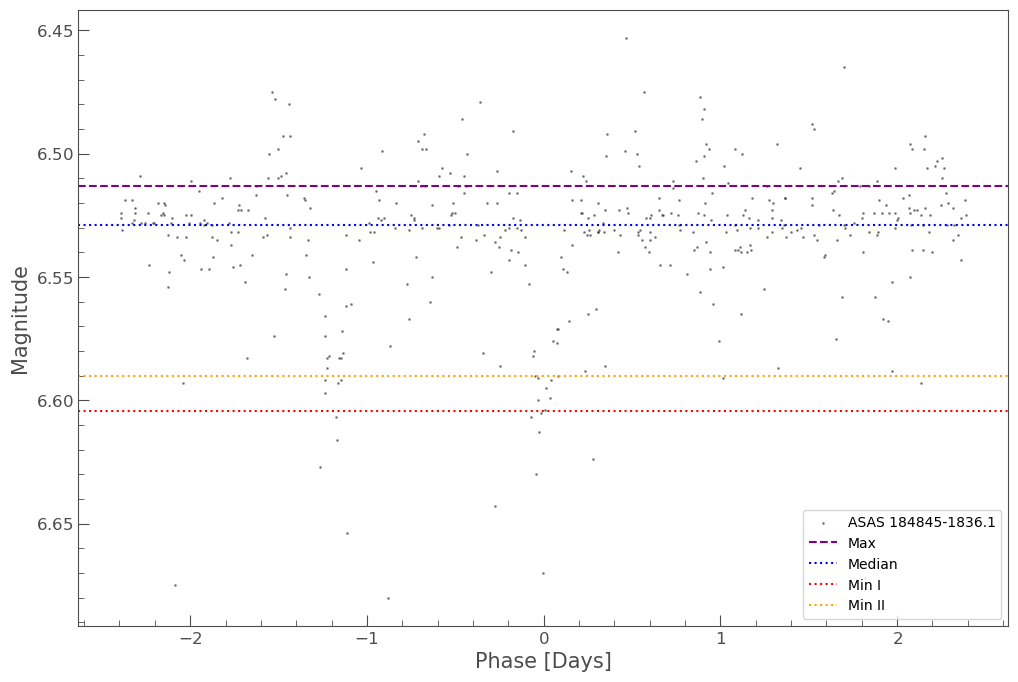

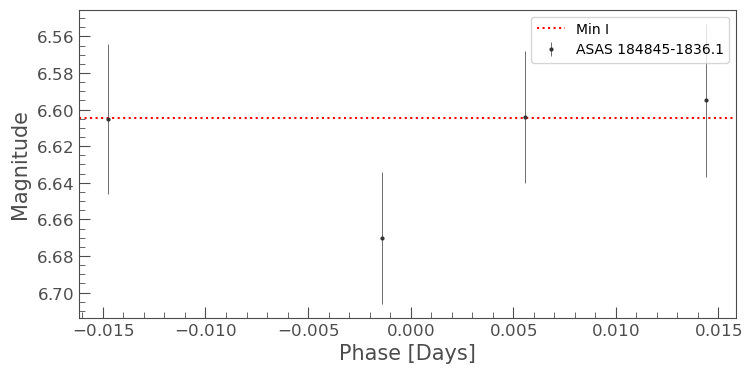

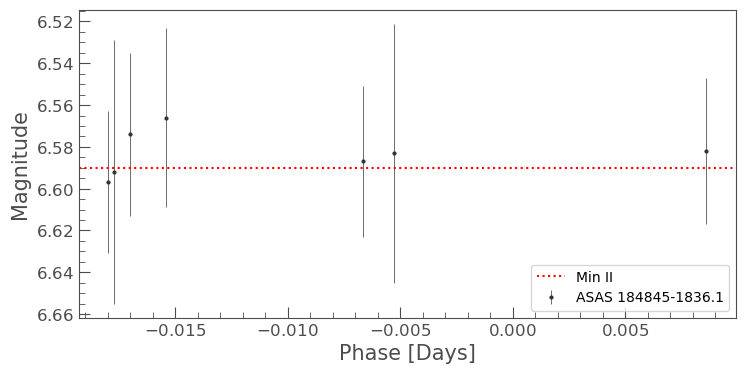

In [147]:
%matplotlib inline

median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + 4.33, period=period_final).truncate(0 - 30 /24/60, 0 + 30 /24/ 60)  # the offset is from above cell
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)


lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 30 /24/60, 0 + 30 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd_final, period=period_final).truncate(0 - 30 /24/60, 0 + 30 /24/ 60)
# print("Min II mag # num data points:", len(lc_zoom_min_ii))
# min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)  # the 6.583 mag looks too bright,
print("Min II mag: manaul override ")
min_ii_flux_mag = 6.59


lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ax.set_ylim(*ylim);

ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

ax = tplt.errorbar(lc_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [max_flux_mag, median_flux_mag, min_flux_mag, min_ii_flux_mag]])


# ampitude
# use ASAS3 results as it's in V band, plus the amplitude looks more accurate than TESS (with sautarted pixels making eclipse amplitude smaller)
amp_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)) , 2)  

amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 2)  

amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 2)  

print((amp_flux_mag, amp_min_i_flux_mag, amp_min_ii_flux_mag))

print("Range: ", max_flux_mag, min_flux_mag)

### Determine ellipsoidal amplitude (TESS)

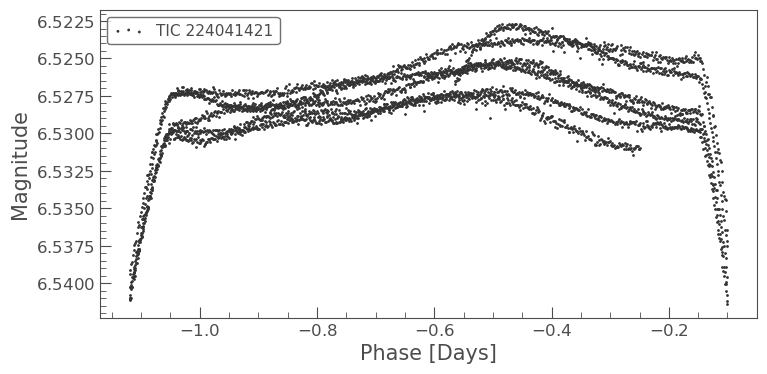

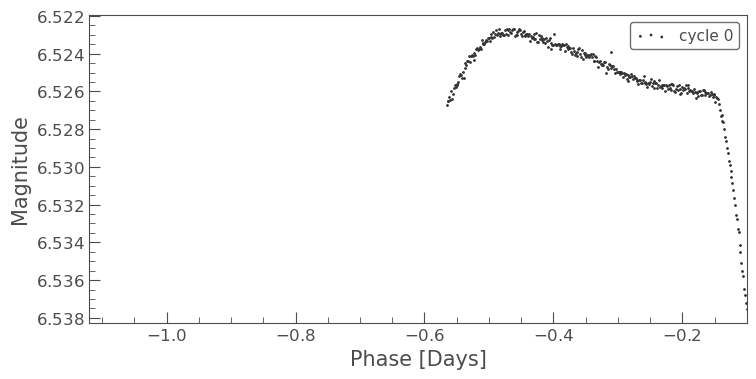

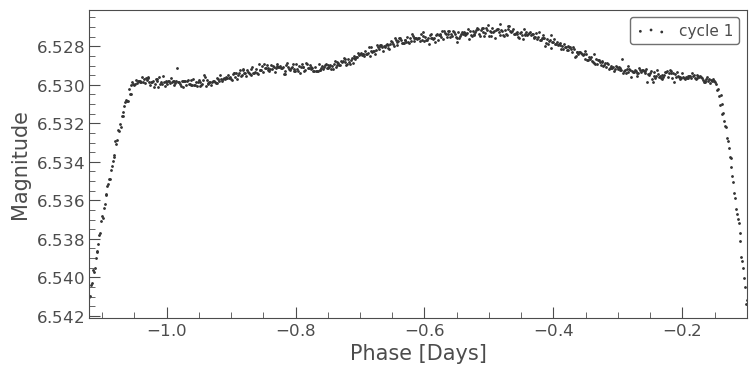

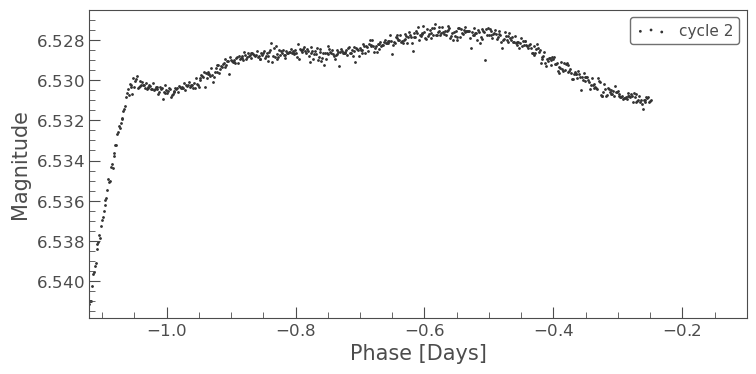

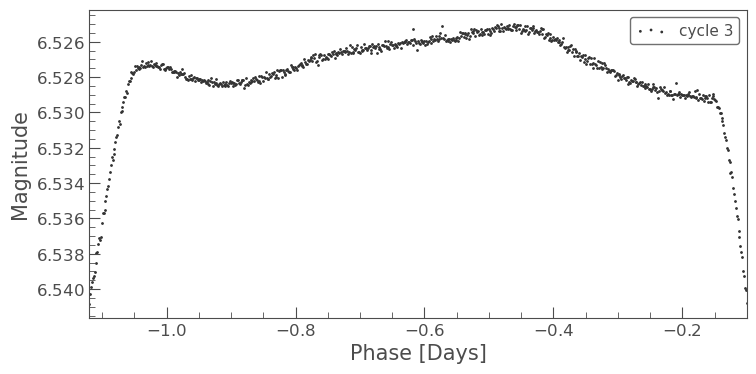

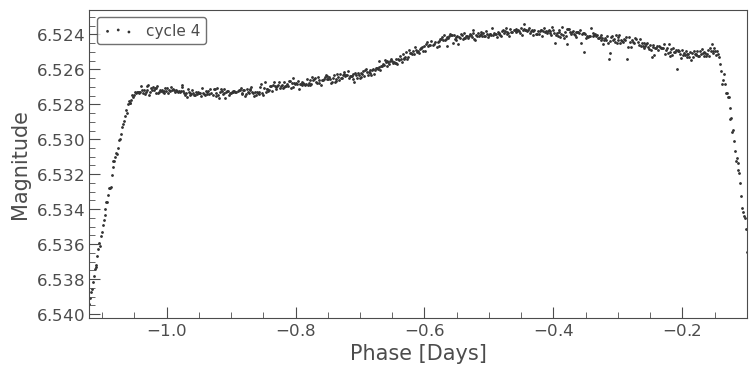

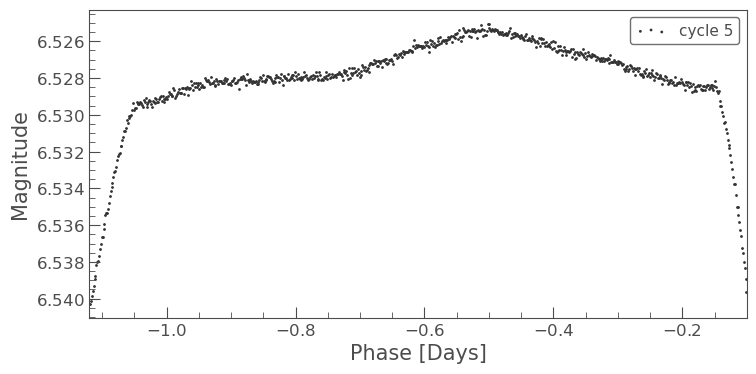

In [80]:
lc = lc_combined_dict["TESS"]

lc_zoom_ell = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(-1.12, -0.1)

ax = tplt.scatter(lc_zoom_ell);

for c in np.unique(lc_zoom_ell.cycle):
    ax = tplt.scatter(lc_zoom_ell[lc_zoom_ell.cycle == c], label=f"cycle {c}");
    ax.set_xlim(-1.12, -0.1);


## Plots for VSX

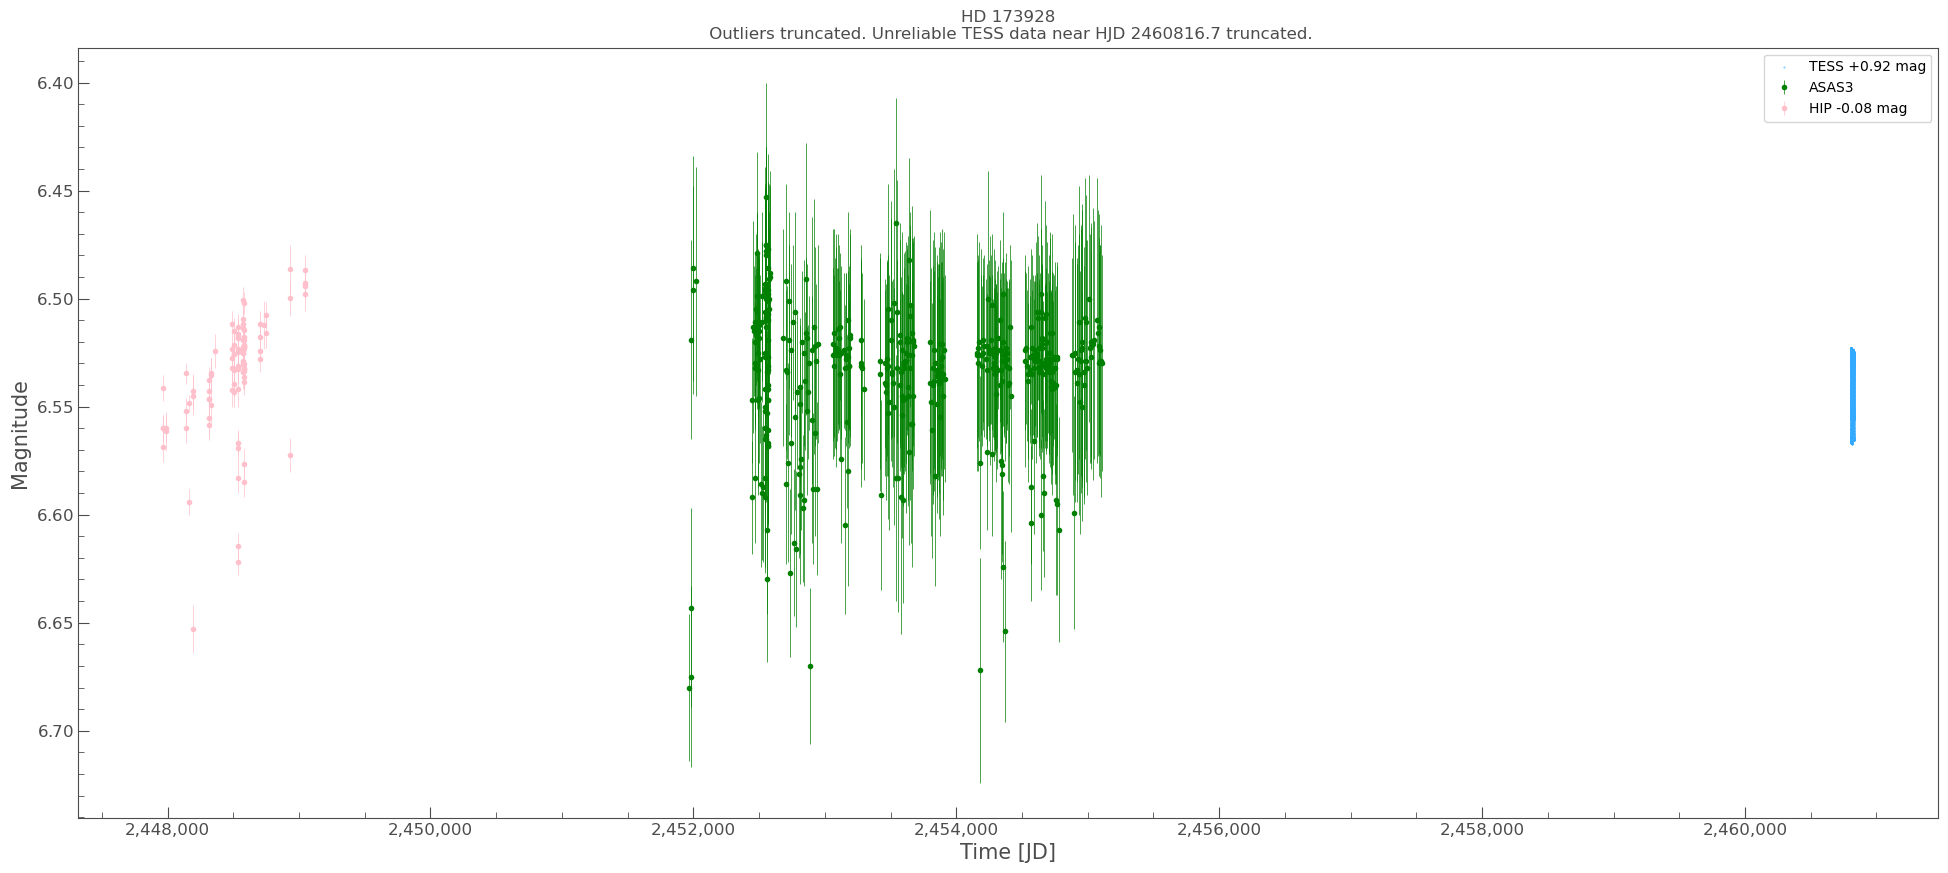

In [64]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
ax.set_title(ax.get_title() + "\n Outliers truncated. Unreliable TESS data near HJD 2460816.7 truncated.");

#### Phase Plot



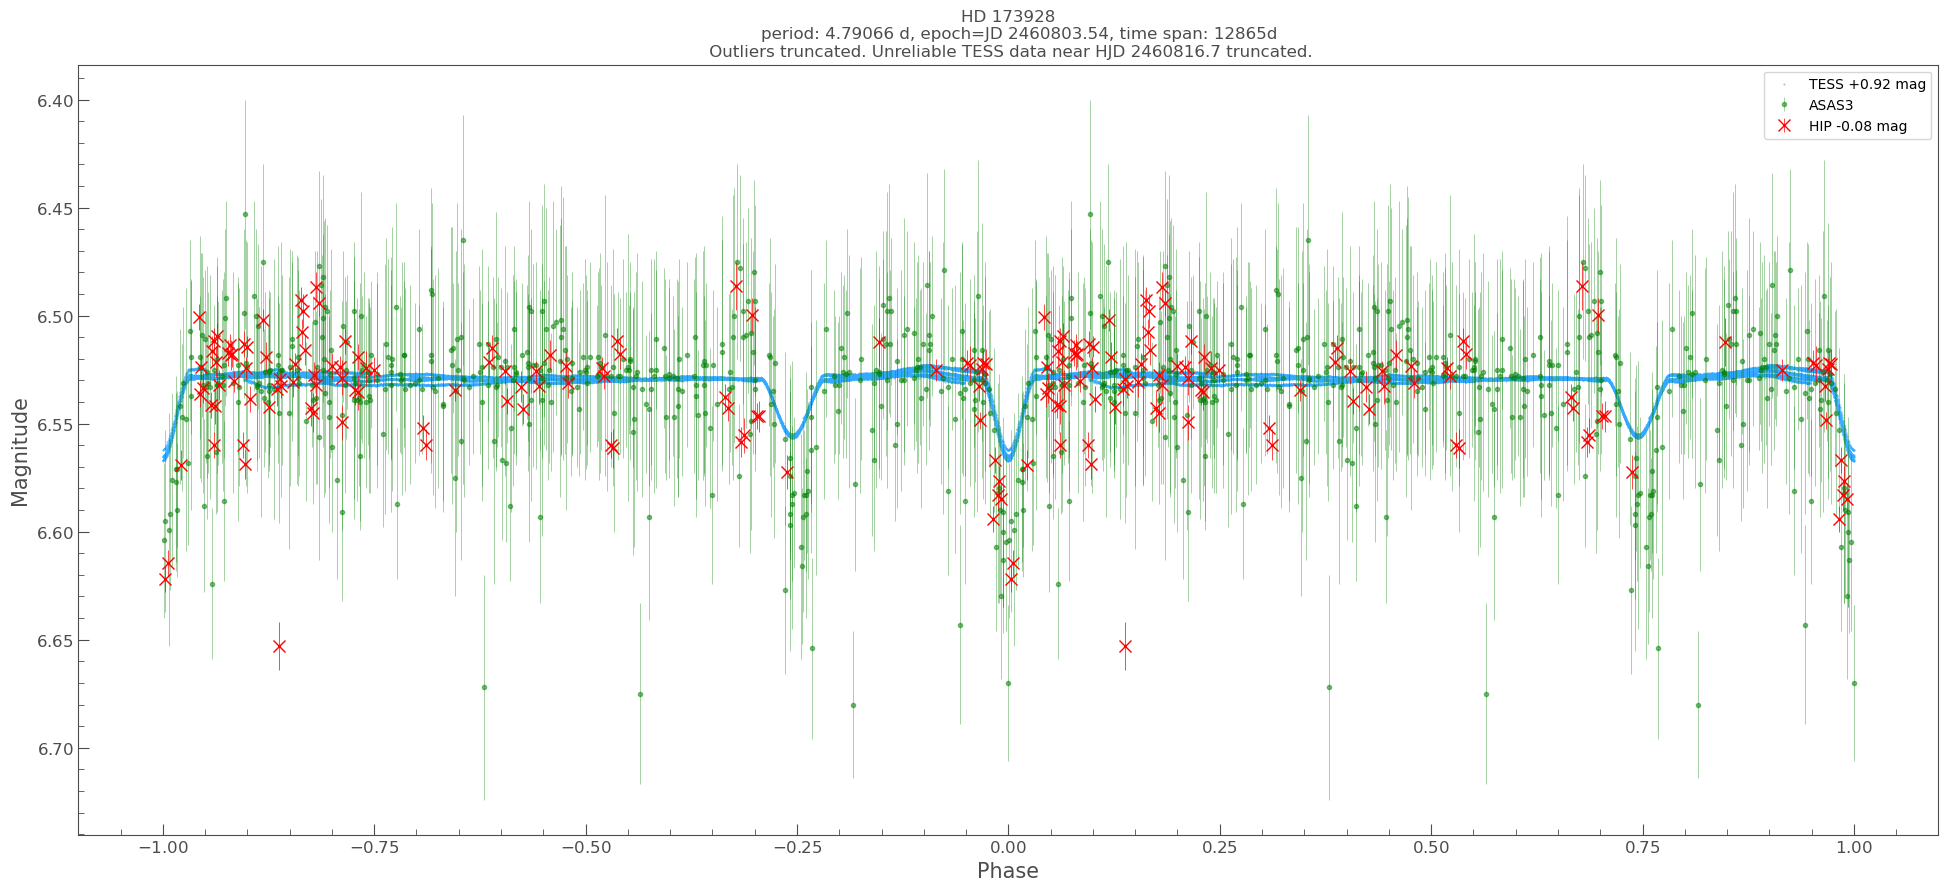

In [148]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[1][1]["alpha"] = 0.5  # make ASAS3 data less dense visually
plot_options[2][1]["c"] = "red"  # make the relative sparse HIP data more prominent
plot_options[2][1]["marker"] = "x"
plot_options[2][1]["markersize"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\n Outliers truncated. Unreliable TESS data near HJD 2460816.7 truncated.");

# # to visualize the amplitude adopted
# ax.axhline(6.61, c="gray", linestyle="--");
# ax.axhline(6.61 - amp_flux_mag, c="gray", linestyle="--");

# # to visualize the range adopted
# ax.axhline(max_flux_mag, c="gray", linestyle="--");
# ax.axhline(min_flux_mag, c="gray", linestyle="--");
# print(f"Range: {max_flux_mag:.2f} - {min_flux_mag:.2f}") 

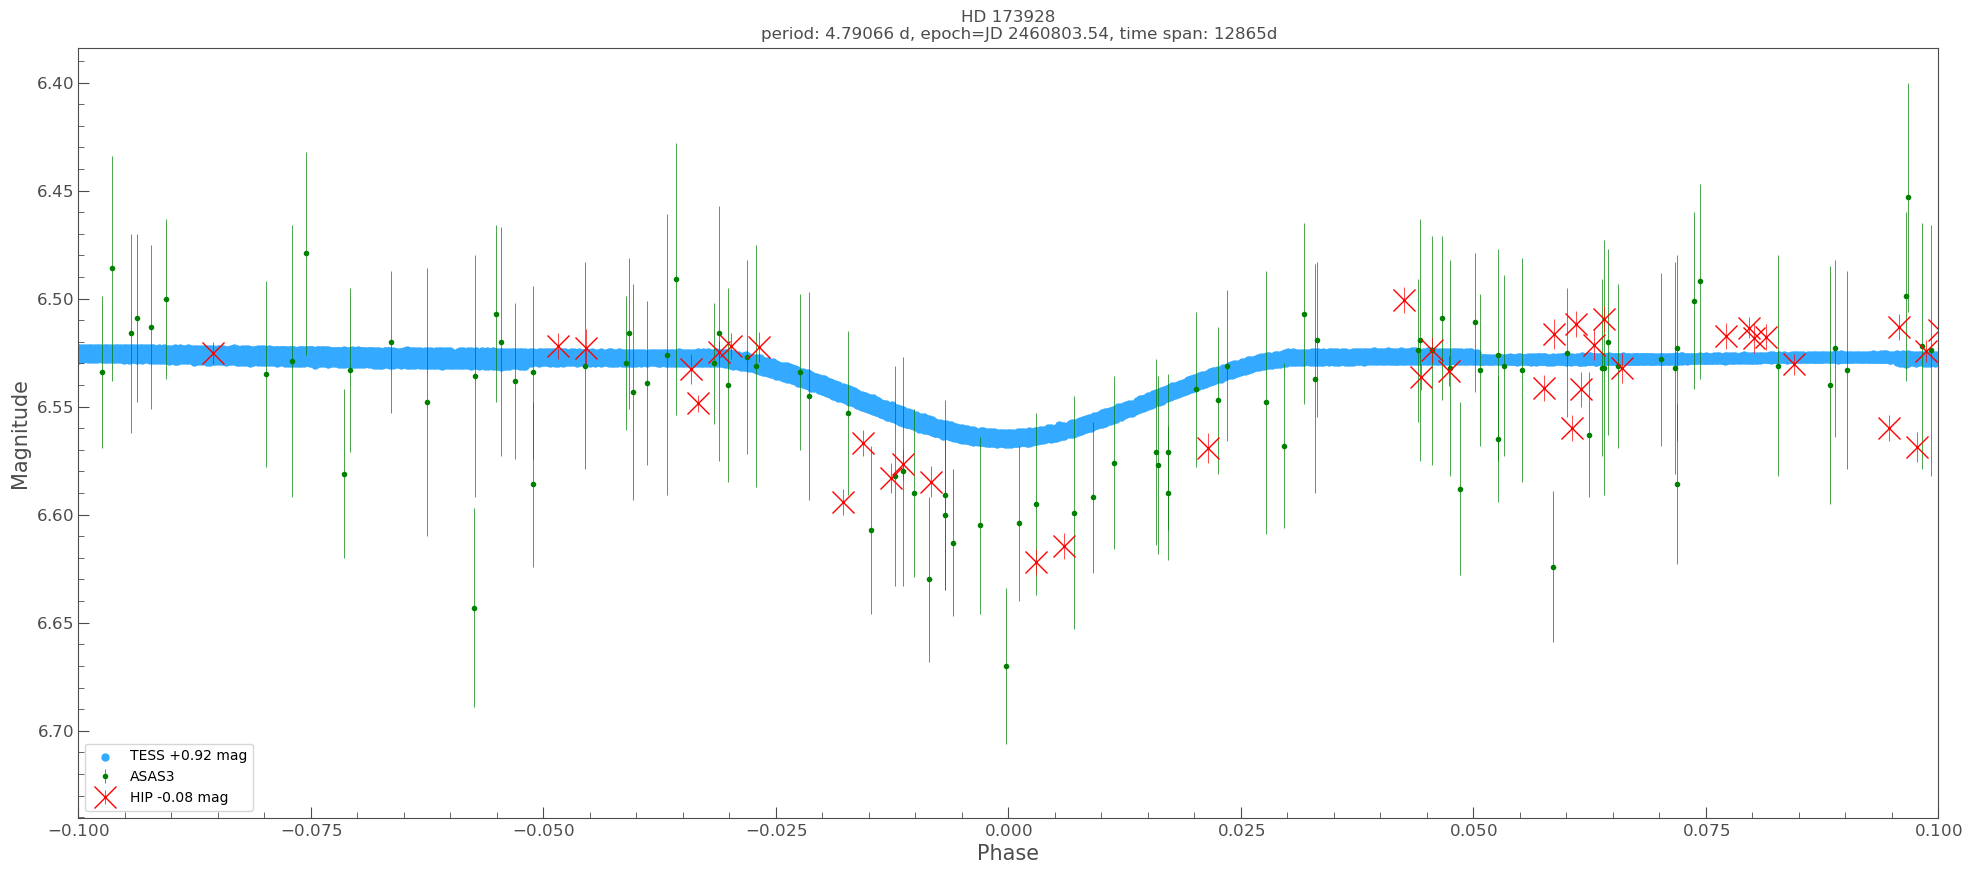

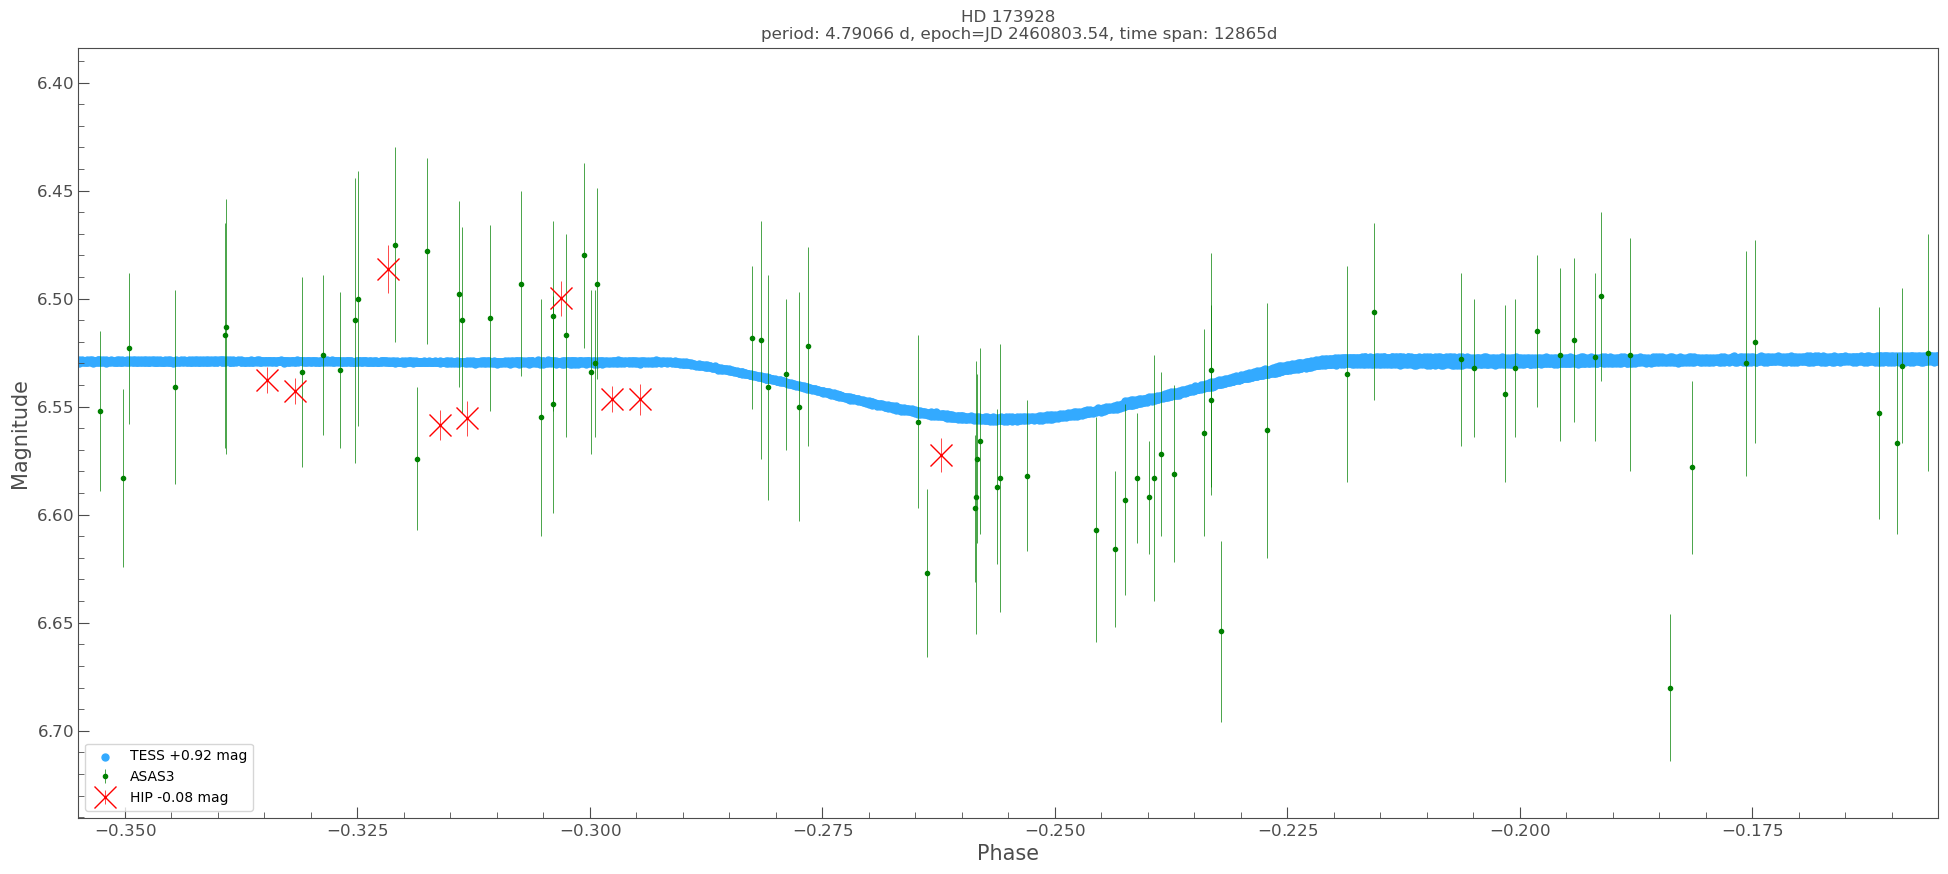

In [81]:

# zoom plot Min I
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
# - make TESS more visible:  larger dots
plot_options_zoom[0][1]["s"] = 25
plot_options_zoom[2][1]["c"] = "red"   # make the relative sparse HIP data more prominent
plot_options_zoom[2][1]["marker"] = "x"
plot_options_zoom[2][1]["markersize"] = 16

# # to workaround astropy TypeError: cannot write to unmasked output when doing matplotlib errorbar  plot
# _lc = lc_combined_dict['TESS'].copy()
# _lc.flux_err = _lc.flux_err.filled(np.nan)

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    # dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    # dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(24, 10),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.set_xlim(epoch_phase_min_ii_final  -0.1, epoch_phase_min_ii_final  +0.1);  # to see Min II in details


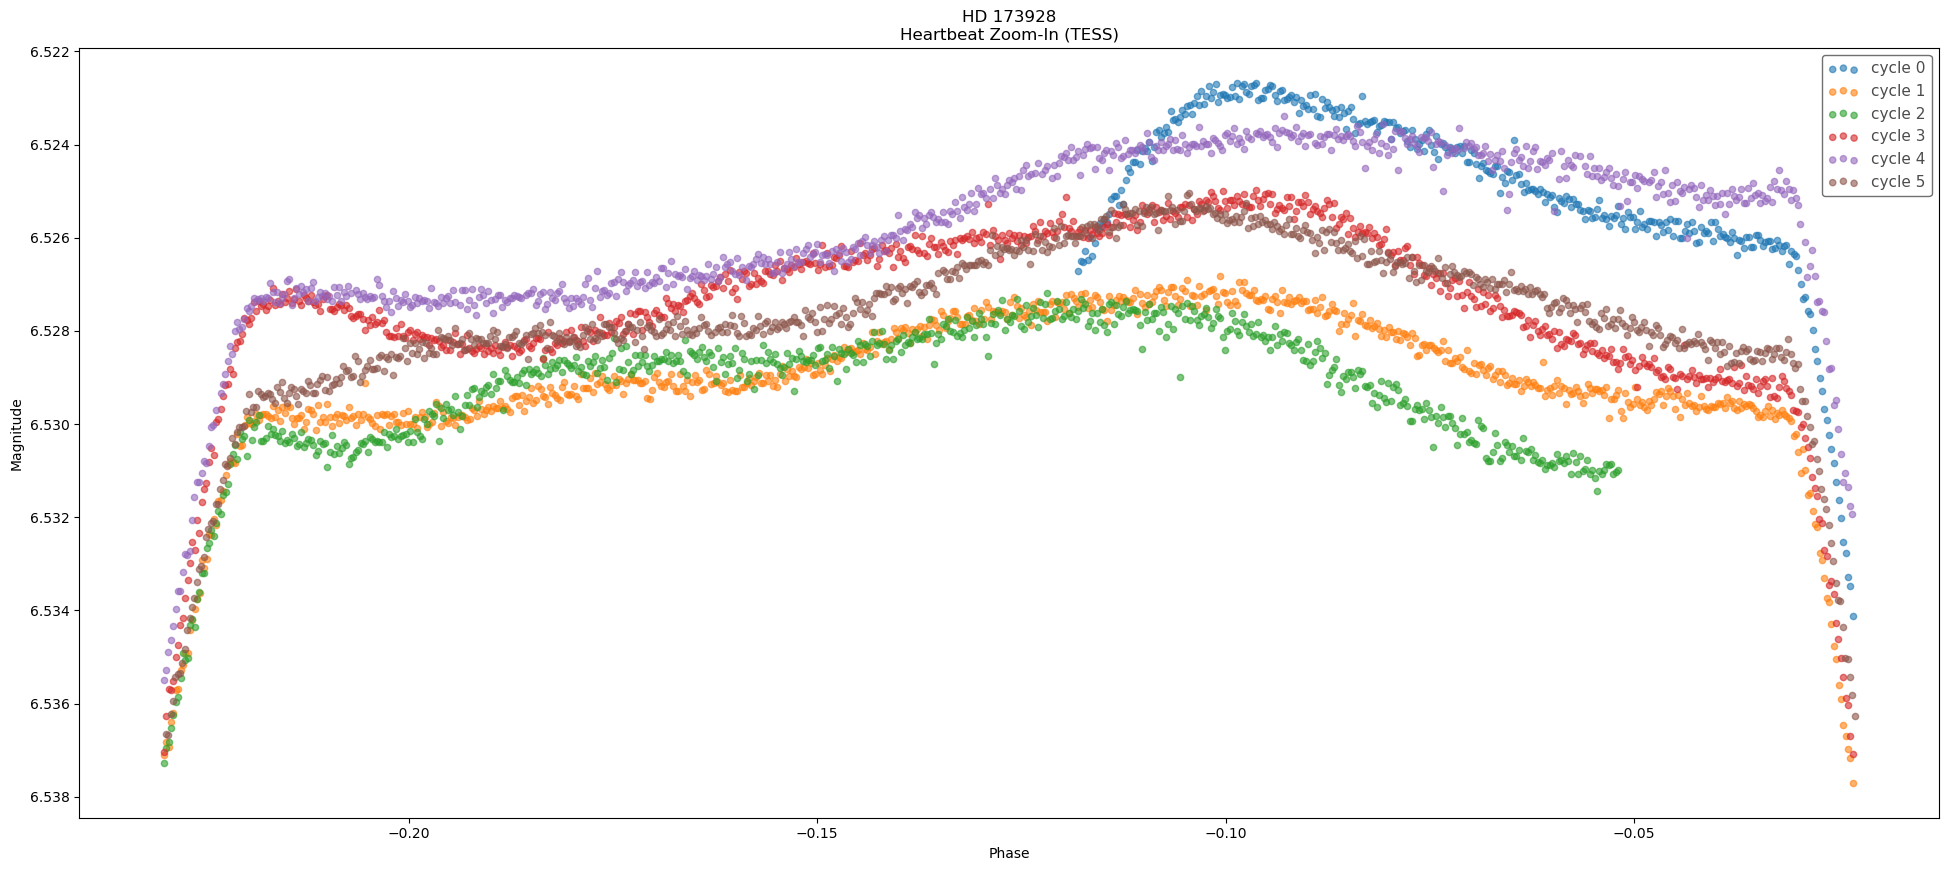

In [135]:
ax = plt.figure(figsize=(24, 10)).gca()

lc_f = lc_f_res["TESS"].truncate(-0.23, -0.023);  # just the ELL / heartbeat part
# lc_f = lc_f_res["TESS"].truncate(-0.27, 0.01);  # covers the 2 elcipses as well
# tplt.scatter(lc_f, ax=ax)

for c in np.unique(lc_f.cycle):
    tplt.scatter(lc_f[lc_f.cycle == c], ax=ax, label=f"cycle {c}", s=81, alpha=0.6)

ax.set_title(f"{primary_name}\nHeartbeat Zoom-In (TESS)");
ax.set_xlabel("Phase");

In [99]:
# zoom plot for the ellipsoidal variation (TESS only) / HB


# # # to workaround astropy TypeError: cannot write to unmasked output when doing matplotlib errorbar  plot
# # _lc = lc_combined_dict['TESS'].copy()
# # _lc.flux_err = _lc.flux_err.filled(np.nan)

# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     dict(TESS=lc_combined_dict["TESS"]),
#     period=period_final  ,
#     epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     target_name=primary_name,
#     # duration_hr=duration_hr_min_i_final  ,  # for plotting only
#     figsize=(24, 10),
#     plot_options=plot_options_zoom,
#     # mag_shift_precision=2,  #
# );
# ax.set_ylim(*ylim);
# ax.legend(loc="lower left");
# # ax.axvline(0, c="gray", linestyle="dotted");
# ax.set_xlim(-0.23, -0.023);


## VSX Report Table

In [21]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [155]:
import bibs_utils
reload(bibs_utils)

# TIC are not added, given the entry refers to thw whole system per SO
other_names = f"TIC {tic},HIP 92301,2MASS J18484541-1836041,UCAC4 357-163490"  # TIC is not used as the primary name so it's here. Others: ExoFOP  and  SIMBAD
other_names += ",ASAS J184845-1836.1"  # use ASAS-3 data
other_names += ",WDS J18488-1836,GSC 06285-00193"  # Useful IDs from SIMBAD, 
other_names += ",SAO 161848"  # bright stars, add IDs for other well known catalogs on SIMBAD. No GJ, CD, CPD names

remarks = (
    f"""Eccentric system. Min I amplitude {amp_min_i_flux_mag} V. Min II at phase {vsx_phase(epoch_phase_min_ii_final)}, amplitude {amp_min_ii_flux_mag} V, duration {100 * duration_hr_min_ii_final / 24 / period_final:.1f}% . Heartbeat amplitude 0.003 TESS. """
    f"""Uncertain identification: the target is a known double star. Per WDS, A has V = 6.73 , B has V = 8.14 and was 0.4" to SE in 2021. The magnitudes and amplitudes given are the composite AB. The position given is the position of the component A from Hipparcos. """
    f"""AB has an orbital period of 909.7 yr per 2022MNRAS.517.2925C ."""
)
# ^^^^^^
# AB orbital period:  https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ6902c363852e1&-out.add=.&-source=J/MNRAS/517/2925/tablea3&recno=2582
#
# From SO: The mag of A B from WDS in the remarks: there is a transform needed
# The WDS magnitudes are Vt magnitudes taken from the Tycho Double Star Catalog, not V magnitudes, so you have to transform them to V. We get V= 6.74; B-V= 1.20 and V= 8.13; B-V= 0.03. These values are rounded so they may be 6.73 and 8.14 too, but for our purposes they are enough. 


revision_comment = "Type, period, epoch, eclipse duration from TESS, ASAS-3 and Hipparcos data. Eclipse amplitudes from ASAS-3 data. Position from Hipparcos. Spectral type from 1988mcts.book.....H ."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    # Position=f"{target_coord.ra.value}, {target_coord.dec.value}",  # do not use the default Gaia DR3 position per SO
    Position="282.18921735, -18.60114984",  #  component A position from Hipparcos  -- https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-source=I%2F239%2Fhip_main%2CI%2F239%2Fh_dm_com%2CI%2F239%2Ftyc_main&HIP=92301
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA+HB",
    Spectral_Type="K1III+A1V",  # from 1988mcts.book.....H, by way of SIMBAD SO: component A is the brighter one per Tycho double star / I/239/h_dm_com . Thus it's the giant (III)(
    Spectral_Type_Uncertain=False,

    # mag in mean - amp
    # # mean mag: a bright star, roughly similar to  or 
    # # Maximum_Magnitude=f"6.46",  #  use HIP transformed V -- https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ69027eee2a6cef&-out.add=.&-source=I/239/hip_main&recno=92217 , 
    # Maximum_Magnitude=f"6.467",  #  GCPD V (Geneva) = 6.462 , transformed Johnson V = 6.467  GCPD V (actually Geneva V, slighlty different from Johnson V)  --  https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ686eee352cfb71&-out.add=.&-source=II/167/catalog&recno=82628
    # Maximum_Magnitude_band="V",
    # Minimum_Magnitude=f"{amp_flux_mag}:",   # in ASAS-3
    # Minimum_Magnitude_band="V",  
    # Minimum_Is_Amplitude=True,

    # SO feedback: use range instead. I use ASAS-3 V data
    Maximum_Magnitude=f"{max_flux_mag:.2f}", 
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{min_flux_mag:.2f}",
    Minimum_Magnitude_band="V",  
    Minimum_Is_Amplitude=False,

    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",  
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.1f}", 
    Discoverer="Sam Lee", 
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference1_Name=BIBS.ASAS3_N,
    Reference1_Bib=BIBS.ASAS3_B,
    Reference2_Name=BIBS.HIP_N,
    Reference2_Bib=BIBS.HIP_B,
    # X_Reference2_Name=BIBS.GAIA_DR3_N,  # for position (the composite), we use HIP posistion
    # X_Reference2_Bib=BIBS.GAIA_DR3_B,  
    # Reference4_Name="Hauck, B.; et al., 1990, General Catalogue of Photometric Data",  # for mean V mag  -- no longer reported
    # Reference4_Bib="1995yCat.2167....0H",
    Reference5_Name="Houk, N.; Smith-Moore, M., 1988, Michigan Catalogue of Two-dimensional Spectral Types for the HD Stars. Volume 4, Declinations -26°.0 to -12°.0.",  # spectral type
    Reference5_Bib="1988mcts.book.....H",
    Reference6_Name="Mason, B. D.; et al., 2025, The Washington Visual Double Star Catalog (Mason+ 2001-2020)",
    Reference6_Bib="2025yCat....102026M",
    Reference7_Name="Chulkov, D.; Malkov, O., 2022, Visual binary stars with known orbits in Gaia EDR3",
    Reference7_Bib="2022MNRAS.517.2925C",
)


def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic224041421_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
print("""
tic224041421_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from ASAS-3, Hipparcos, and  TESS (SPOC PDCSAP_FLUX) data, shifted to ASAS-3. Outliers truncated. TESS data near HJD 2460816.7 truncated as they are distorted (associated with a TESS momentum dump).
tic224041421_phase_plot_eclipses_hb_zoom.png :  EA Phase Plot (HB Zoom-In) - EA Phase Plot from TESS data, zoomed-in to the heartbeat.
""")



Other Names (1 line each):
TIC 224041421
HIP 92301
2MASS J18484541-1836041
UCAC4 357-163490
ASAS J184845-1836.1
WDS J18488-1836
GSC 06285-00193
SAO 161848

Eccentric system. Min I amplitude 0.08 V. Min II at phase 0.745, amplitude 0.06 V, duration 7.0% . Heartbeat amplitude 0.003 TESS. Uncertain identification: the target is a known double star. Per WDS, A has V = 6.73 , B has V = 8.14 and was 0.4" to SE in 2021. The magnitudes and amplitudes given are the composite AB. The position given is the position of the component A from Hipparcos. AB has an orbital period of 909.7 yr per 2022MNRAS.517.2925C .

Type, period, epoch, eclipse duration from TESS, ASAS-3 and Hipparcos data. Eclipse amplitudes from ASAS-3 data. Position from Hipparcos. Spectral type from 1988mcts.book.....H .


,Field,Value
0,Position,"282.18921735, -18.60114984"
1,Primary_Name,HD 173928
2,Other_Names,"TIC 224041421,HIP 92301,2MASS J18484541-1836041,UCAC4 357-163490,ASAS J184845-1836.1,WDS J18488-1836,GSC 06285-00193,SAO 161848"
3,Variable_Type,EA+HB
4,Spectral_Type,K1III+A1V
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,6.51
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,6.60
9,Minimum_Magnitude_band,V



tic224041421_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from ASAS-3, Hipparcos, and  TESS (SPOC PDCSAP_FLUX) data, shifted to ASAS-3. Outliers truncated. TESS data near HJD 2460816.7 truncated as they are distorted (associated with a TESS momentum dump).
tic224041421_phase_plot_eclipses_hb_zoom.png :  EA Phase Plot (HB Zoom-In) - EA Phase Plot from TESS data, zoomed-in to the heartbeat.

